<a href="https://colab.research.google.com/github/rachelyayra/Electricity-theft-detection-project/blob/main/ElectricityTheftDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELECTRICITY THEFT DETECTION USING SMOTE WITH TOMEK LINK UNDERSAMPLING
This project, developed as a final year project, focuses on the detection of electricity theft using machine learning techniques.
* The primary approach employed here is the combination of SMOTE (Synthetic Minority Over-sampling Technique) with Tomek Links to address the issue of data imbalance.
*Additionally, various features, including the coefficient of variation, peak and minimum consumption months, and shape of each data point, are extracted and used to train an XGBoost classifier.

## SETUP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**INSTALLING AND IMPORTING NEEDED PACKAGES**

In [2]:
pip install tslearn

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.combine import SMOTETomek
import math
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils import shuffle

## DATA PREPROCESSING

**SETTING RANDOM STATE**

In [4]:
random_state = 100

**LOADING DATA**

In [5]:
illegal_path = '/content/drive/My Drive/finalyearprojectdata/illegal_xx.csv'
legal_path = '/content/drive/My Drive/finalyearprojectdata/legal_mm.csv'

In [6]:
illegal_df = pd.read_csv(illegal_path)
legal_df = pd.read_csv(legal_path)
illegal_df = pd.DataFrame(illegal_df.to_numpy())
legal_df = pd.DataFrame(legal_df.to_numpy())

**CHECKING FOR MISSING VALUES**

In [7]:
legal_df = legal_df.fillna(0)
legal_df.isnull().any().any()

False

**Assigning Targets to Each Class**

In [8]:
legal_data = legal_df
legal_data['label'] = 0
illegal_data = illegal_df
illegal_data['label'] = 1
print(legal_data)

         0      1      2      3      4      5      6      7      8      9  \
0    427.0  355.0  429.0  305.0  435.0  427.0  355.0  429.0  435.0  478.0   
1    331.0  297.0  237.0  326.0  317.0  331.0  297.0  237.0  326.0  317.0   
2    202.0  176.0  220.0  215.0  188.0  202.0  223.0  223.0  222.0  237.0   
3    266.0  225.0  234.0  254.0  224.0  211.0  196.0  258.0  260.0  269.0   
4    292.0  235.0  320.0  371.0  319.0  292.0  235.0  320.0  371.0  319.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
308  193.0  241.0  229.0  230.0  224.0  193.0  241.0  229.0  230.0  224.0   
309   17.0   10.0   53.0   80.0    0.0   17.0   10.0   53.0   80.0    0.0   
310  120.0  115.0  124.0  121.0  160.0  120.0  115.0  124.0  121.0  160.0   
311   99.0   99.0  126.0  143.0  110.0  200.0  192.0  212.0  242.0  231.0   
312   55.0   43.0   58.0   60.0   43.0   58.0   60.0   43.0   58.0   60.0   

        10     11  label  
0    429.0  435.0      0  
1    237.0  326.0    

**CREATION OF A RAW AND UNPROCESSED DATASET**

In [9]:
X_points = pd.concat([legal_data, illegal_data])
y_raw = X_points['label']
X_raw = X_points.drop(columns= 'label')
print(X_raw)

        0      1      2      3      4      5      6      7      8      9  \
0   427.0  355.0  429.0  305.0  435.0  427.0  355.0  429.0  435.0  478.0   
1   331.0  297.0  237.0  326.0  317.0  331.0  297.0  237.0  326.0  317.0   
2   202.0  176.0  220.0  215.0  188.0  202.0  223.0  223.0  222.0  237.0   
3   266.0  225.0  234.0  254.0  224.0  211.0  196.0  258.0  260.0  269.0   
4   292.0  235.0  320.0  371.0  319.0  292.0  235.0  320.0  371.0  319.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
42    0.0   13.0  171.0  107.0   85.0   82.0   88.0  101.0  153.0  176.0   
43    0.0    0.0    0.0   19.0  438.0  424.0  419.0  391.0  410.0  450.0   
44  192.0   20.0   13.0   64.0    0.0    0.0    0.0    0.0    0.0    0.0   
45    0.0  293.0  318.0  301.0  244.0  204.0  174.0  135.0  174.0  222.0   
46    0.0    0.0    0.0    0.0    0.0   10.0   18.0   16.0   19.0   19.0   

       10     11  
0   429.0  435.0  
1   237.0  326.0  
2   223.0  222.0  
3   258.0  

**Split Data into Training and Test DATA**


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_raw,y_raw, test_size=0.4, random_state=random_state, stratify= y_raw)

In [11]:
X_train

0      1      2      3      4      5      6      7      8      9  \
171   17.0   20.0   15.0   13.0   50.0   17.0   13.0   38.0   52.0   13.0   
31    99.0  105.0   45.0   33.0   58.0   99.0  105.0  109.0  113.0  121.0   
85    18.0   15.0   19.0   10.0   82.0   18.0   15.0   19.0   10.0   82.0   
298  220.0  226.0  273.0  259.0  143.0  266.0  277.0  238.0   68.0  288.0   
164   22.0   29.0   63.0   36.0   28.0   32.0   24.0   22.0    4.0   18.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
118   84.0   82.0   88.0   87.0   73.0   84.0   82.0   88.0   87.0   73.0   
299   53.0   15.0    7.0   12.0   20.0   16.0   22.0   19.0   26.0   27.0   
83    67.0   52.0   56.0   88.0   92.0   89.0   67.0   56.0   88.0   92.0   
42    40.0   36.0   65.0   70.0   68.0   30.0   45.0   68.0   70.0   72.0   
263   14.0   35.0   10.0   25.0   20.0  150.0  149.0   32.0   29.0   30.0   

        10     11  
171   38.0   52.0  
31   109.0  113.0  
85    19.0   10.0  
298  238.0   68.0  
164   22.0    4.0  
..     ...    ...  
118   88.0   87.0  
299   19.0   26.0  
83    56.0   88.0  
42    68.0   70.0  
263   32.0   29.0  

[216 rows x 12 columns]

### SMOTE WITH TOMEK LINK UNDERSAMPLING



**Creation of Unsampled Dataset**

In [12]:
unsampled_train = pd.DataFrame.copy(X_train)
unsampled_train['label'] = y_train
legal_unsampled = unsampled_train.loc[unsampled_train['label'] == 0].drop(columns= 'label')
print(legal_unsampled)
illegal_unsampled = unsampled_train.loc[unsampled_train['label'] == 1].drop(columns= 'label')
print(illegal_unsampled)

         0      1      2      3      4      5      6      7      8      9  \
171   17.0   20.0   15.0   13.0   50.0   17.0   13.0   38.0   52.0   13.0   
31    99.0  105.0   45.0   33.0   58.0   99.0  105.0  109.0  113.0  121.0   
85    18.0   15.0   19.0   10.0   82.0   18.0   15.0   19.0   10.0   82.0   
298  220.0  226.0  273.0  259.0  143.0  266.0  277.0  238.0   68.0  288.0   
164   22.0   29.0   63.0   36.0   28.0   32.0   24.0   22.0    4.0   18.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
118   84.0   82.0   88.0   87.0   73.0   84.0   82.0   88.0   87.0   73.0   
299   53.0   15.0    7.0   12.0   20.0   16.0   22.0   19.0   26.0   27.0   
83    67.0   52.0   56.0   88.0   92.0   89.0   67.0   56.0   88.0   92.0   
42    40.0   36.0   65.0   70.0   68.0   30.0   45.0   68.0   70.0   72.0   
263   14.0   35.0   10.0   25.0   20.0  150.0  149.0   32.0   29.0   30.0   

        10     11  
171   38.0   52.0  
31   109.0  113.0  
85    19.0   10

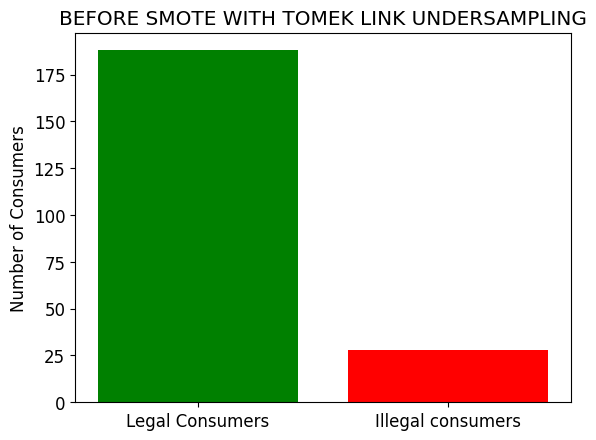

In [13]:
plt.bar(['Legal Consumers', 'Illegal consumers'], [len(legal_unsampled), len(illegal_unsampled)], color=['green','red'])
plt.title('BEFORE SMOTE WITH TOMEK LINK UNDERSAMPLING')
plt.ylabel('Number of Consumers')
plt.savefig('/content/drive/My Drive/Befor SMOTE.png')
plt.show()

***To balance the training data, SMOTE with Tomek Link Undersampling is used***


In [14]:
smt = SMOTETomek(random_state=random_state)
X_train, y_train = smt.fit_resample(X_train, y_train)
train = pd.DataFrame.copy(X_train)
X_train['label'] = y_train

In [15]:
X_train

0           1           2           3           4           5  \
0     17.000000   20.000000   15.000000   13.000000   50.000000   17.000000   
1     99.000000  105.000000   45.000000   33.000000   58.000000   99.000000   
2     18.000000   15.000000   19.000000   10.000000   82.000000   18.000000   
3    220.000000  226.000000  273.000000  259.000000  143.000000  266.000000   
4     22.000000   29.000000   63.000000   36.000000   28.000000   32.000000   
..          ...         ...         ...         ...         ...         ...   
369   66.819802    0.000000    0.000000    0.000000   11.993298    0.000000   
370    4.037392    0.000000    0.000000    5.652348    0.000000   12.128866   
371    0.000000    0.000000    0.000000    6.590120    0.000000   44.798716   
372   38.532788   17.974149   26.896597   12.403534    4.870746    4.286256   
373    4.936871    0.000000    0.000000    6.911619    0.000000    0.795427   

              6           7           8           9          10          11  \
0     13.000000   38.000000   52.000000   13.000000   38.000000   52.000000   
1    105.000000  109.000000  113.000000  121.000000  109.000000  113.000000   
2     15.000000   19.000000   10.000000   82.000000   19.000000   10.000000   
3    277.000000  238.000000   68.000000  288.000000  238.000000   68.000000   
4     24.000000   22.000000    4.000000   18.000000   22.000000    4.000000   
..          ...         ...         ...         ...         ...         ...   
369    0.000000    4.730084   38.476923   63.033511  272.459406  166.953085   
370    0.000000   51.678612   29.876698   41.657912   40.198085   58.930780   
371    3.451968    0.000000    1.569076   43.192130   48.819760   67.288195   
372    6.819044    0.000000    0.000000    0.000000    0.000000    0.000000   
373    0.000000   63.191947   36.532844   38.239891   35.340897   52.454530   

     label  
0        0  
1        0  
2        0  
3        0  
4        0  
..     ...  
369      1  
370      1  
371      1  
372      1  
373      1  

[374 rows x 13 columns]

In [16]:
legal_df = X_train.loc[X_train['label'] == 0].drop(columns= 'label')
print(legal_df)
illegal_df = X_train.loc[X_train['label'] == 1].drop(columns= 'label')
print(illegal_df)

         0      1      2      3      4      5      6      7      8      9  \
0     17.0   20.0   15.0   13.0   50.0   17.0   13.0   38.0   52.0   13.0   
1     99.0  105.0   45.0   33.0   58.0   99.0  105.0  109.0  113.0  121.0   
2     18.0   15.0   19.0   10.0   82.0   18.0   15.0   19.0   10.0   82.0   
3    220.0  226.0  273.0  259.0  143.0  266.0  277.0  238.0   68.0  288.0   
4     22.0   29.0   63.0   36.0   28.0   32.0   24.0   22.0    4.0   18.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
210   84.0   82.0   88.0   87.0   73.0   84.0   82.0   88.0   87.0   73.0   
211   53.0   15.0    7.0   12.0   20.0   16.0   22.0   19.0   26.0   27.0   
212   67.0   52.0   56.0   88.0   92.0   89.0   67.0   56.0   88.0   92.0   
213   40.0   36.0   65.0   70.0   68.0   30.0   45.0   68.0   70.0   72.0   
214   14.0   35.0   10.0   25.0   20.0  150.0  149.0   32.0   29.0   30.0   

        10     11  
0     38.0   52.0  
1    109.0  113.0  
2     19.0   10

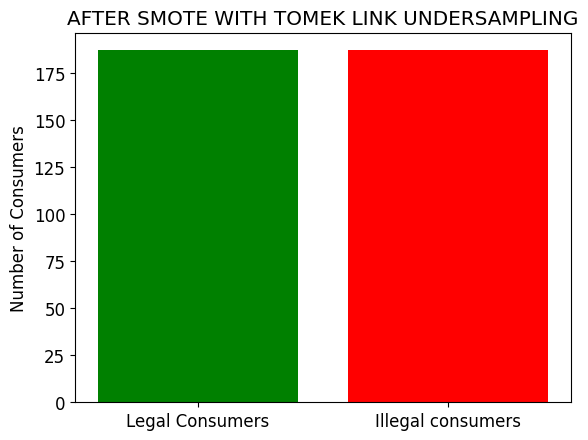

In [17]:
plt.bar(['Legal Consumers', 'Illegal consumers'], [len(legal_df), len(illegal_df)], color=['green','red'])
plt.title('AFTER SMOTE WITH TOMEK LINK UNDERSAMPLING')
plt.ylabel('Number of Consumers')
plt.savefig('/content/drive/My Drive/After SMOTE.png')
plt.show()

## NORMALIZE DATASET FOR CLUSTERING


1.   Min Max Normalization
2.   Z-score Normalization



In [18]:
clusterData = pd.concat([illegal_df, legal_df]).reset_index().drop(columns = 'index')

In [19]:
clusterData

0     1     2     3     4      5      6      7      8      9     10  \
0     0.0   0.0   0.0   0.0   0.0   63.0    0.0    0.0    0.0   57.0   62.0   
1     0.0   0.0   0.0   0.0   0.0    0.0  172.0  208.0  307.0  278.0  170.0   
2    36.0  17.0  23.0   5.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     0.0   0.0   0.0   0.0   0.0    0.0   63.0   24.0   64.0    0.0   63.0   
4     0.0   0.0   0.0   0.0   0.0   10.0   18.0   16.0   19.0   19.0   20.0   
..    ...   ...   ...   ...   ...    ...    ...    ...    ...    ...    ...   
369  84.0  82.0  88.0  87.0  73.0   84.0   82.0   88.0   87.0   73.0   88.0   
370  53.0  15.0   7.0  12.0  20.0   16.0   22.0   19.0   26.0   27.0   19.0   
371  67.0  52.0  56.0  88.0  92.0   89.0   67.0   56.0   88.0   92.0   56.0   
372  40.0  36.0  65.0  70.0  68.0   30.0   45.0   68.0   70.0   72.0   68.0   
373  14.0  35.0  10.0  25.0  20.0  150.0  149.0   32.0   29.0   30.0   32.0   

        11  
0     88.0  
1    142.0  
2      0.0  
3    107.0  
4     22.0  
..     ...  
369   87.0  
370   26.0  
371   88.0  
372   70.0  
373   29.0  

[374 rows x 12 columns]

### Min-max Normalization

In [20]:
scaler = MinMaxScaler()
norm = scaler.fit_transform(clusterData.T)
norm = pd.DataFrame(norm)
norm = norm.T
print(norm)

           0         1         2         3         4         5         6   \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.715909  0.000000   
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.560261   
2    1.000000  0.472222  0.638889  0.138889  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.588785   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.454545  0.818182   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.733333  0.600000  1.000000  0.933333  0.000000  0.733333  0.600000   
370  1.000000  0.173913  0.000000  0.108696  0.282609  0.195652  0.326087   
371  0.375000  0.000000  0.100000  0.900000  1.000000  0.925000  0.375000   
372  0.238095  0.142857  0.833333  0.952381  0.904762  0.000000  0.357143   
373  0.028571  0.178571  0.000000  0.107143  0.071429  1.000000  0.992857   

           7         8         9         10        11  
0    0.000000  0.00

In [21]:
norm

0         1         2         3         4         5         6   \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.715909  0.000000   
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.560261   
2    1.000000  0.472222  0.638889  0.138889  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.588785   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.454545  0.818182   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.733333  0.600000  1.000000  0.933333  0.000000  0.733333  0.600000   
370  1.000000  0.173913  0.000000  0.108696  0.282609  0.195652  0.326087   
371  0.375000  0.000000  0.100000  0.900000  1.000000  0.925000  0.375000   
372  0.238095  0.142857  0.833333  0.952381  0.904762  0.000000  0.357143   
373  0.028571  0.178571  0.000000  0.107143  0.071429  1.000000  0.992857   

           7         8         9         10        11  
0    0.000000  0.000000  0.647727  0.704545  1.000000  
1    0.677524  1.000000  0.905537  0.553746  0.462541  
2    0.000000  0.000000  0.000000  0.000000  0.000000  
3    0.224299  0.598131  0.000000  0.588785  1.000000  
4    0.727273  0.863636  0.863636  0.909091  1.000000  
..        ...       ...       ...       ...       ...  
369  1.000000  0.933333  0.000000  1.000000  0.933333  
370  0.260870  0.413043  0.434783  0.260870  0.413043  
371  0.100000  0.900000  1.000000  0.100000  0.900000  
372  0.904762  0.952381  1.000000  0.904762  0.952381  
373  0.157143  0.135714  0.142857  0.157143  0.135714  

[374 rows x 12 columns]

### Z-score Normalization

In [22]:
scale = StandardScaler()
znorm = scale.fit_transform(clusterData.T)
znorm = pd.DataFrame(znorm)
znorm = znorm.T
print(znorm)

           0         1         2         3         4         5         6   \
0   -0.690783 -0.690783 -0.690783 -0.690783 -0.690783  1.243410 -0.690783   
1   -0.928731 -0.928731 -0.928731 -0.928731 -0.928731 -0.928731  0.572366   
2    2.539282  0.889834  1.410712 -0.151923 -0.585988 -0.585988 -0.585988   
3   -0.744968 -0.744968 -0.744968 -0.744968 -0.744968 -0.744968  1.009536   
4   -1.129328 -1.129328 -1.129328 -1.129328 -1.129328 -0.036430  0.837888   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.080322 -0.305223  0.851412  0.658640 -2.040177  0.080322 -0.305223   
370  2.835613 -0.621712 -1.349570 -0.894659 -0.166801 -0.530730  0.015164   
371 -0.457445 -1.403883 -1.151500  0.867568  1.119952  0.930664 -0.457445   
372 -1.225416 -1.490371  0.430552  0.761745  0.629268 -1.887804 -0.894223   
373 -0.690083 -0.240727 -0.775675 -0.454706 -0.561695  2.220034  2.198637   

           7         8         9         10        11  
0   -0.690783 -0.69

## FEATURE EXTRACTION


1.   Coefficient of Variation
2.   Peak and Minimum consumption month
2.   DTW Cluster






### Coefficient of Variation

In [23]:
std_mm = legal_df.T.std()
mean_mm = legal_df.T.mean()
features_mm = pd.concat([std_mm, mean_mm], axis = 1)
features_mm["cOfVar"] = features_mm[0]/features_mm[1]
features_mm.drop(columns=[0,1], inplace= True)
features_mm['label'] = 0
print(features_mm)

       cOfVar  label
0    0.584910      0
1    0.319343      0
2    0.992066      0
3    0.364330      0
4    0.606484      0
..        ...    ...
210  0.064823      0
211  0.525796      0
212  0.222945      0
213  0.269542      0
214  1.055385      0

[187 rows x 2 columns]


In [24]:
std_xx = illegal_df.T.std()
mean_xx = illegal_df.T.mean()
features_xx = pd.concat([std_xx, mean_xx], axis = 1)
features_xx["cOfVar"] = features_xx[0]/features_xx[1]
features_xx.drop(columns=[0,1], inplace= True)
features_xx['label'] = 1
print(features_xx)

       cOfVar  label
10   1.512002      1
14   1.124617      1
15   1.782401      1
16   1.402028      1
18   0.924856      1
..        ...    ...
369  1.635662      1
370  1.110401      1
371  1.399709      1
372  1.347213      1
373  1.187944      1

[187 rows x 2 columns]


### Peak Month and Dip Month Extraction



In [25]:
features_xx['peakMonth'] = illegal_df.T.idxmax().to_numpy()
temp_xx = illegal_df.T.idxmax().to_numpy()
f_xx ={}
for i in temp_xx:
  f_xx[i] = f_xx.get(i, 0) + 1
print(f_xx)
print(features_xx)

{11: 39, 8: 8, 0: 36, 2: 16, 7: 10, 3: 16, 10: 17, 9: 21, 4: 13, 1: 7, 5: 4}
       cOfVar  label  peakMonth
10   1.512002      1         11
14   1.124617      1          8
15   1.782401      1          0
16   1.402028      1         11
18   0.924856      1         11
..        ...    ...        ...
369  1.635662      1         10
370  1.110401      1         11
371  1.399709      1         11
372  1.347213      1          0
373  1.187944      1          7

[187 rows x 3 columns]


In [26]:
features_xx['minMonth'] = illegal_df.T.idxmin().to_numpy()
# temp_xx = illegal_df.idxmin().to_numpy()
# f_xx ={}
# for i in temp_xx:
#   f_xx[i] = f_xx.get(i, 0) + 1
# print(f_xx)
print(features_xx)

       cOfVar  label  peakMonth  minMonth
10   1.512002      1         11         0
14   1.124617      1          8         0
15   1.782401      1          0         4
16   1.402028      1         11         0
18   0.924856      1         11         0
..        ...    ...        ...       ...
369  1.635662      1         10         1
370  1.110401      1         11         1
371  1.399709      1         11         0
372  1.347213      1          0         7
373  1.187944      1          7         1

[187 rows x 4 columns]


In [27]:
features_mm['peakMonth'] = legal_df.T.idxmax().to_numpy()
# temp_xx = legal_df.idxmax().to_numpy()
# f_xx ={}
# for i in temp_xx:
#   f_xx[i] = f_xx.get(i, 0) + 1
# print(f_xx)
print(features_mm)

       cOfVar  label  peakMonth
0    0.584910      0          8
1    0.319343      0          9
2    0.992066      0          4
3    0.364330      0          9
4    0.606484      0          2
..        ...    ...        ...
210  0.064823      0          2
211  0.525796      0          0
212  0.222945      0          4
213  0.269542      0          9
214  1.055385      0          5

[187 rows x 3 columns]


In [28]:
features_mm['minMonth'] = legal_df.T.idxmin().to_numpy()
# temp_xx = legal_df.idxmin().to_numpy()
# f_xx ={}
# for i in temp_xx:
#   f_xx[i] = f_xx.get(i, 0) + 1
# print(f_xx)
print(features_mm)

       cOfVar  label  peakMonth  minMonth
0    0.584910      0          8         3
1    0.319343      0          9         3
2    0.992066      0          4         3
3    0.364330      0          9         8
4    0.606484      0          2         8
..        ...    ...        ...       ...
210  0.064823      0          2         4
211  0.525796      0          0         2
212  0.222945      0          4         1
213  0.269542      0          9         5
214  1.055385      0          5         2

[187 rows x 4 columns]


In [29]:
Xfull = pd.concat([features_xx, features_mm]).reset_index().drop(columns = 'index')
X = Xfull
print(X)

       cOfVar  label  peakMonth  minMonth
0    1.512002      1         11         0
1    1.124617      1          8         0
2    1.782401      1          0         4
3    1.402028      1         11         0
4    0.924856      1         11         0
..        ...    ...        ...       ...
369  0.064823      0          2         4
370  0.525796      0          0         2
371  0.222945      0          4         1
372  0.269542      0          9         5
373  1.055385      0          5         2

[374 rows x 4 columns]


### DTW Time-series Clustering

Checking for optimal number of clusters

In [30]:
# distortions = []
# K = range(1,25)
# for k in K:
#   kms = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=5,max_iter_barycenter=10,random_state=random_state).fit(norm)
#   distortions.append(kms.inertia_)

In [31]:
# plt.figure(figsize=(16,8))
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [32]:
# distortionz = []
# K = range(1,20)
# for k in K:
#   kmz = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=5,max_iter_barycenter=10,random_state=0).fit(znorm)
#   print(k)
#   distortionz.append(kmz.inertia_)

In [33]:
# plt.figure(figsize=(16,8))
# plt.plot(K, distortionz, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [34]:
# DTW EXTRACTION FOR MINMAX NORMALIZATION
nums = 20
kms = TimeSeriesKMeans(n_clusters=nums, metric="dtw", max_iter=5,max_iter_barycenter=10,random_state=random_state).fit(norm)
print(kms)
labels = kms.labels_

TimeSeriesKMeans(max_iter=5, max_iter_barycenter=10, metric='dtw',
                 n_clusters=20, random_state=100)


In [35]:
# DTW EXTRACTION FOR Z-SCORE NORMALIZATION
nums = 20
kmz = TimeSeriesKMeans(n_clusters=nums, metric="dtw", max_iter=5,max_iter_barycenter=10,random_state=random_state).fit(znorm)
print(kmz)
labelz = kmz.labels_

TimeSeriesKMeans(max_iter=5, max_iter_barycenter=10, metric='dtw',
                 n_clusters=20, random_state=100)


In [36]:
print(labels)
norm['clabels'] = labels
znorm['clabels'] = labelz

[ 5  9  4  5 13 12 13 14  0  6  3  3  4 10 10  9 14 16 19  3  4 16  3  4
  5  0  0 19  9  6 14 16  9  6 12 13  3  5 12 13 19  3 19  3  4 10 16  0
 16 16  0 10  5  4  6 19  3  4 13 14  5 10 18  4  4  9  3  6  2 10  5  5
 14  4 13 13  5  3  3  4  3 13  4 16 19 10 16  5  4 16  3 14 13  5 14 12
 14  3  9  4  9  3 10 10  5  3  3  9 10 13  4 12  4 14 16  3 13  1 13  5
  6 16 14 13  1 16  2  6  5  1 14  1  4  4  9 13  9  5  5  5  5  4 13 12
  9  0  3 12  3 13  4  4  5  4 13  0  3  4  6 10 19 14 19  4  7 19  4  4
 14 19  3 13 10 16  0 12  3 14 12  0 10  3  3  3  5  4  3 15 10  8  7  9
 13  8 14 15 18  7 10  6 16 18  1  7  7 17  2 17 17  1 10 18 14  2  3 16
  0  8  2 15 14  8 18 17 11 15  9  2 18  0  3  2  4 15 16 10 10 13 18 17
  9 19 18 14 10 14 18  3 13 10  8  7  3  7  5 15  6 17  8  7  7  1 18 18
  9  3 16 10  9  1  2  7 15 15 17  8 11  6  0  7  3 10 17 16  0  4 18 11
  8 16 15  3 11 11  8 10  7  8 17 18  1  9 11  1  9 18 15 11  7  1  8 11
 17  9 17 18  4  7 18 14 12  7 18  7 18 11  2 11  8

**VISUALIZING CLUSTERS**

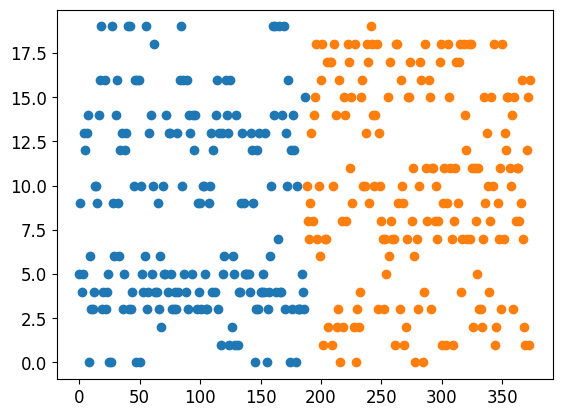

In [37]:
# CLUSTER FOR MINMAX NORMALIZATION
for frame in [norm[0:188], norm[188:398]]:
  plt.scatter(x = frame.index ,y= frame['clabels'])

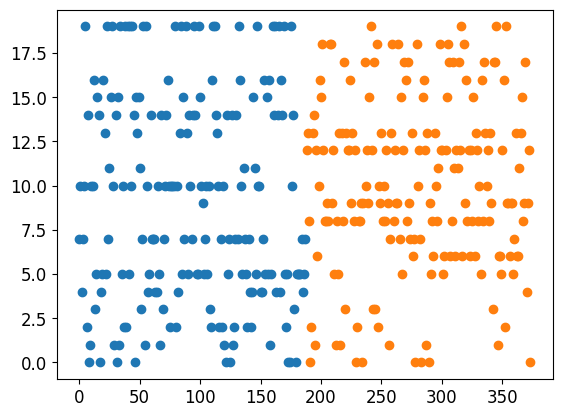

In [38]:
# CLUSTER FOR Z-SCORE NORMALIZATION
for frame in [znorm[0:188], znorm[188:398]]:
  plt.scatter(x = frame.index ,y= frame['clabels'])

In [39]:
temp = norm[norm.columns.difference(["clabels"])]
temp


0         1         2         3         4         5         6  \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.715909  0.000000   
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.560261   
2    1.000000  0.472222  0.638889  0.138889  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.588785   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.454545  0.818182   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.733333  0.600000  1.000000  0.933333  0.000000  0.733333  0.600000   
370  1.000000  0.173913  0.000000  0.108696  0.282609  0.195652  0.326087   
371  0.375000  0.000000  0.100000  0.900000  1.000000  0.925000  0.375000   
372  0.238095  0.142857  0.833333  0.952381  0.904762  0.000000  0.357143   
373  0.028571  0.178571  0.000000  0.107143  0.071429  1.000000  0.992857   

            7         8         9        10        11  
0    0.000000  0.000000  0.647727  0.704545  1.000000  
1    0.677524  1.000000  0.905537  0.553746  0.462541  
2    0.000000  0.000000  0.000000  0.000000  0.000000  
3    0.224299  0.598131  0.000000  0.588785  1.000000  
4    0.727273  0.863636  0.863636  0.909091  1.000000  
..        ...       ...       ...       ...       ...  
369  1.000000  0.933333  0.000000  1.000000  0.933333  
370  0.260870  0.413043  0.434783  0.260870  0.413043  
371  0.100000  0.900000  1.000000  0.100000  0.900000  
372  0.904762  0.952381  1.000000  0.904762  0.952381  
373  0.157143  0.135714  0.142857  0.157143  0.135714  

[374 rows x 12 columns]

In [40]:
tempz = znorm[znorm.columns.difference(["clabels"])]
tempz

0         1         2         3         4         5         6  \
0   -0.690783 -0.690783 -0.690783 -0.690783 -0.690783  1.243410 -0.690783   
1   -0.928731 -0.928731 -0.928731 -0.928731 -0.928731 -0.928731  0.572366   
2    2.539282  0.889834  1.410712 -0.151923 -0.585988 -0.585988 -0.585988   
3   -0.744968 -0.744968 -0.744968 -0.744968 -0.744968 -0.744968  1.009536   
4   -1.129328 -1.129328 -1.129328 -1.129328 -1.129328 -0.036430  0.837888   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.080322 -0.305223  0.851412  0.658640 -2.040177  0.080322 -0.305223   
370  2.835613 -0.621712 -1.349570 -0.894659 -0.166801 -0.530730  0.015164   
371 -0.457445 -1.403883 -1.151500  0.867568  1.119952  0.930664 -0.457445   
372 -1.225416 -1.490371  0.430552  0.761745  0.629268 -1.887804 -0.894223   
373 -0.690083 -0.240727 -0.775675 -0.454706 -0.561695  2.220034  2.198637   

            7         8         9        10        11  
0   -0.690783 -0.690783  1.059201  1.212709  2.010947  
1    0.886549  1.750552  1.497460  0.554911  0.310547  
2   -0.585988 -0.585988 -0.585988 -0.585988 -0.585988  
3   -0.076586  1.037385 -0.744968  1.009536  2.234904  
4    0.619309  0.947178  0.947178  1.056468  1.275048  
..        ...       ...       ...       ...       ...  
369  0.851412  0.658640 -2.040177  0.851412  0.658640  
370 -0.257783  0.379093  0.470075 -0.257783  0.379093  
371 -1.151500  0.867568  1.119952 -1.151500  0.867568  
372  0.629268  0.761745  0.894223  0.629268  0.761745  
373 -0.304920 -0.369114 -0.347716 -0.304920 -0.369114  

[374 rows x 12 columns]

In [41]:
for i in range(20):
    globals()[f"dfz{i}"] = pd.DataFrame().reset_index().drop(columns = 'index')
for i in range(20):
    globals()[f"df{i}"] = pd.DataFrame().reset_index().drop(columns = 'index')

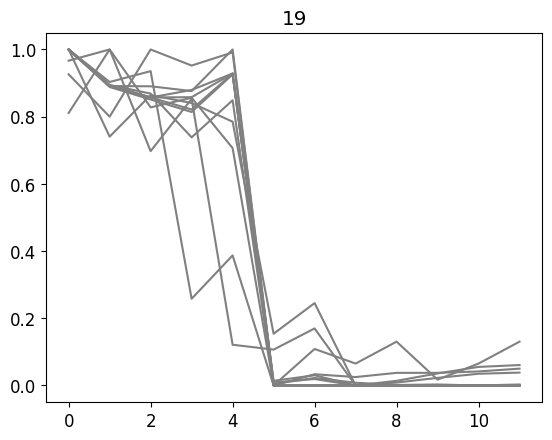

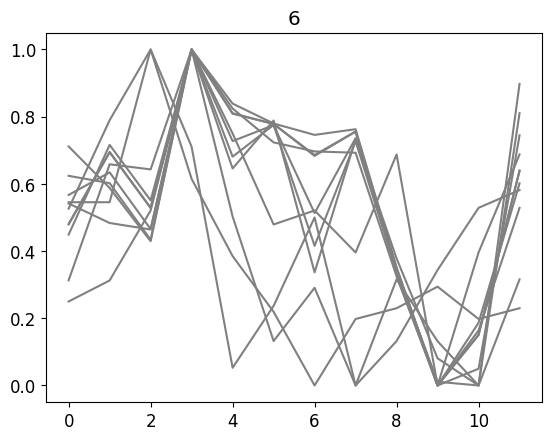

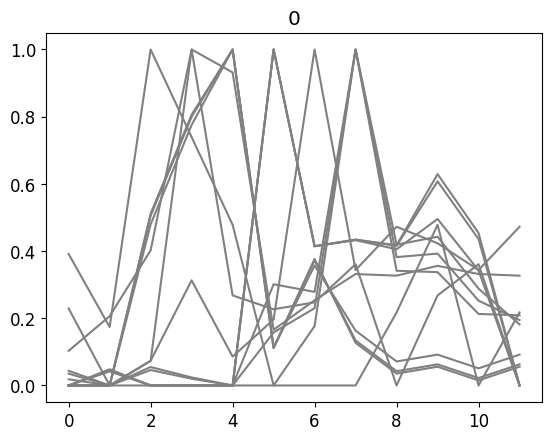

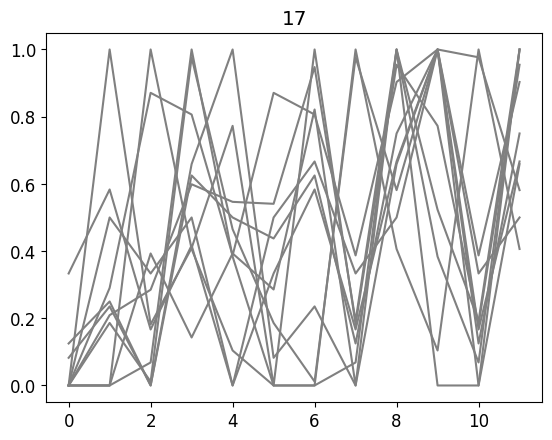

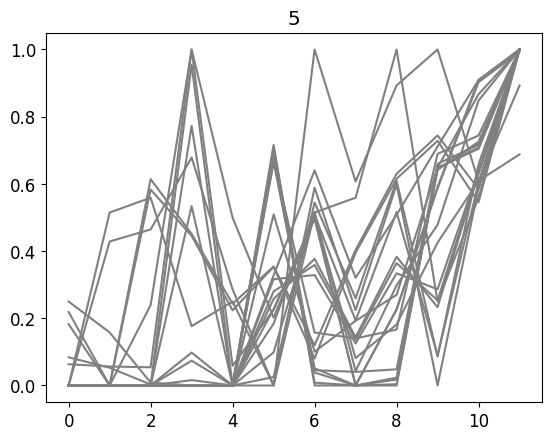

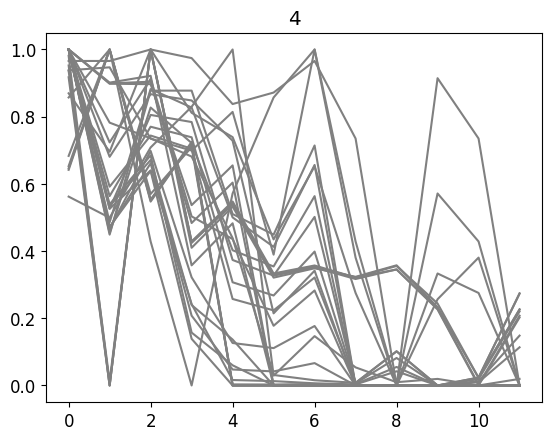

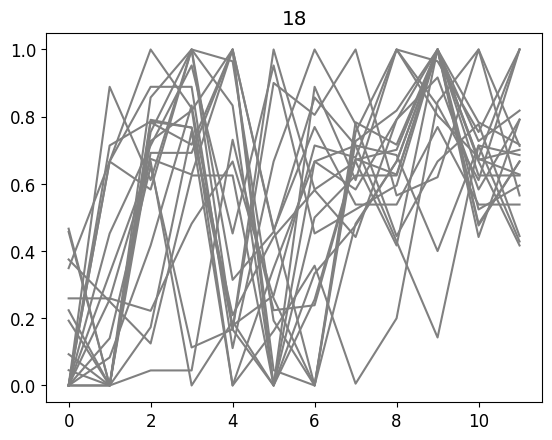

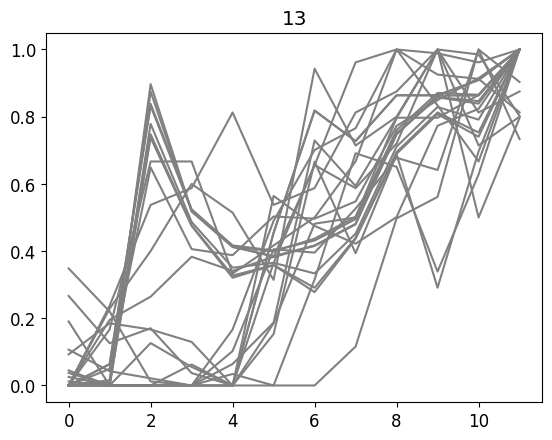

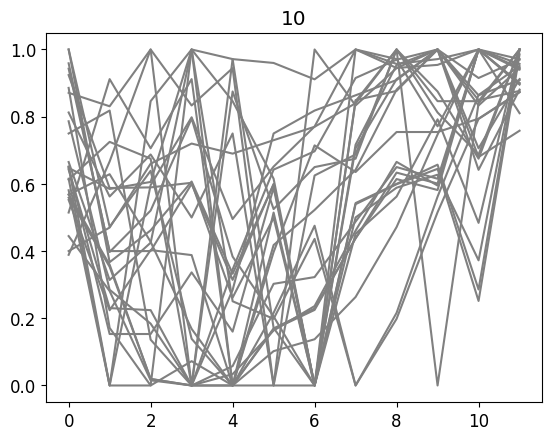

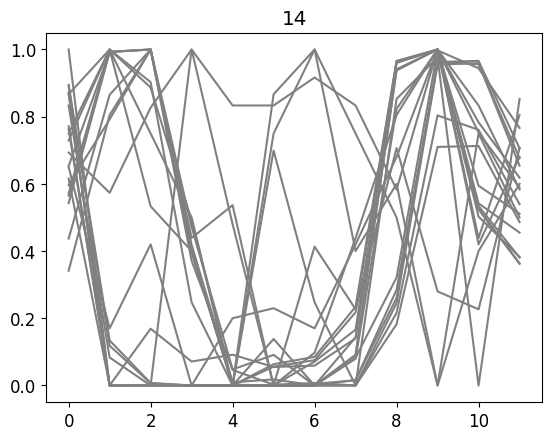

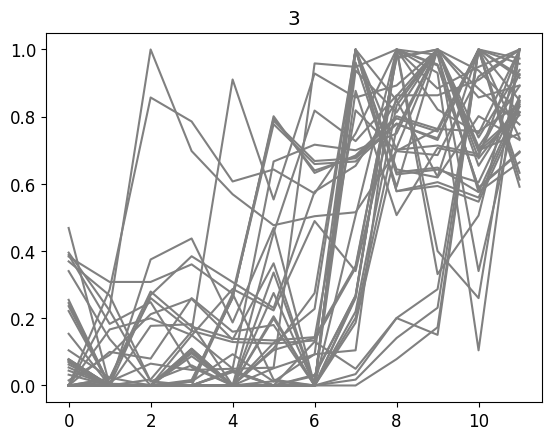

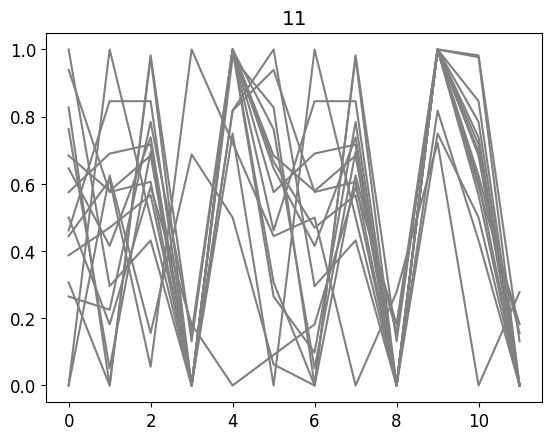

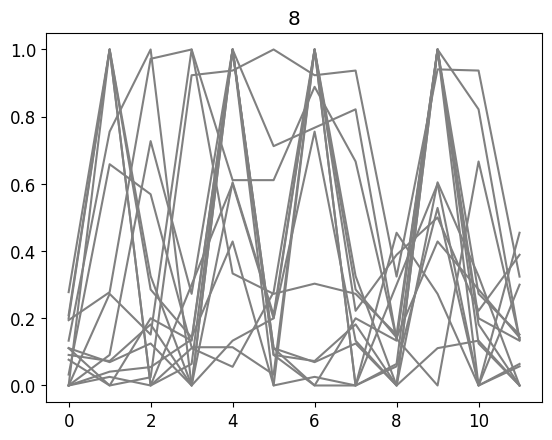

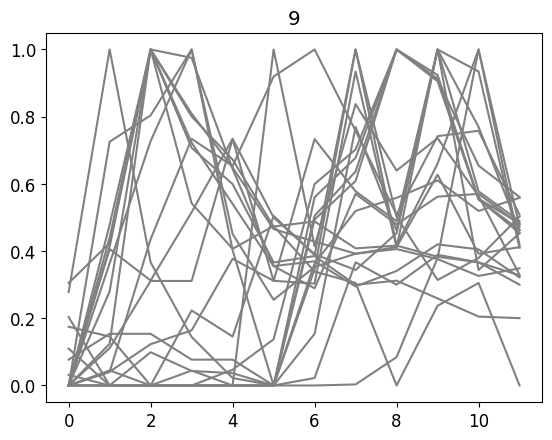

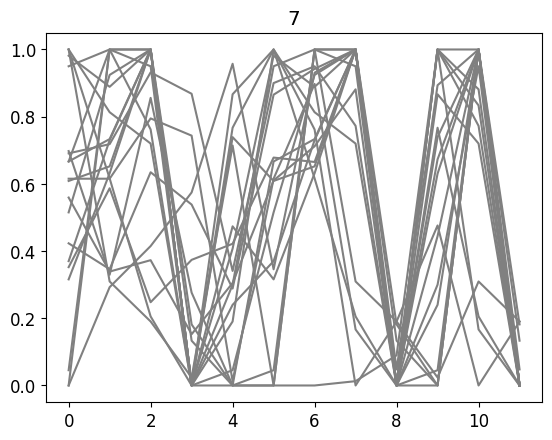

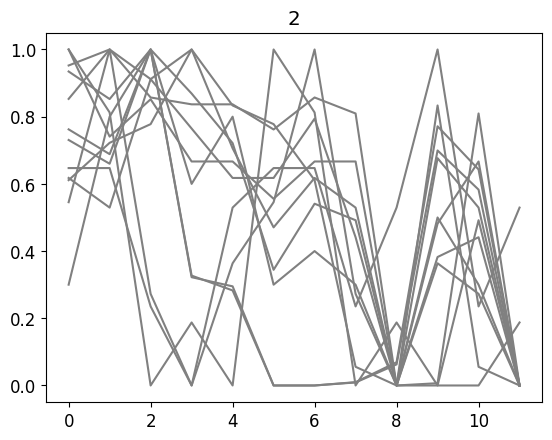

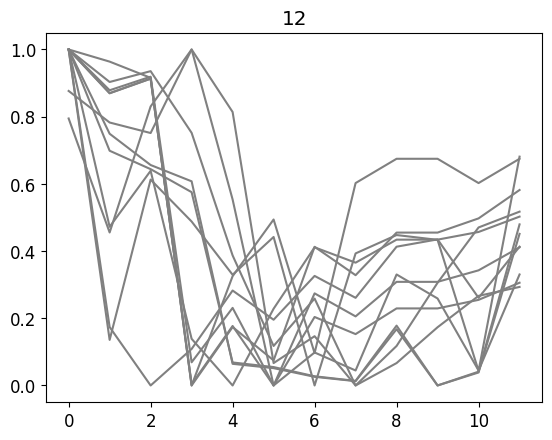

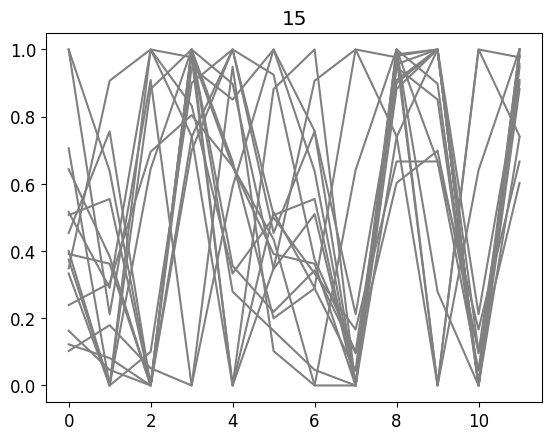

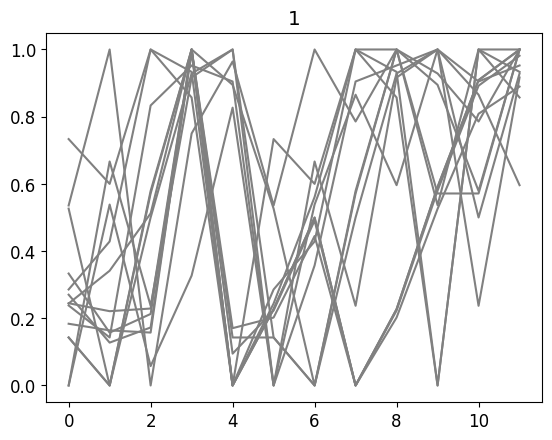

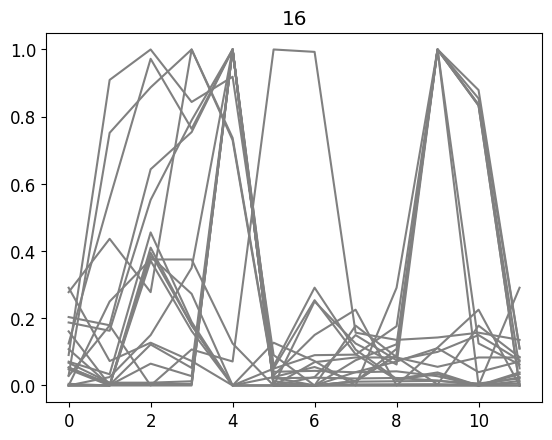

In [42]:
# VISUALIZING CLUSTER SHAPES FOR MINMAX NORMALIZATION
for i in range(len(temp)):
  clus = int(norm.loc[i]['clabels'])
  plt.figure(clus)
  plt.title(clus)
  plt.plot( temp.T.index.values, temp.T[i], color = 'gray')
  globals()[f"df{clus}"]= pd.concat([globals()[f"df{clus}"],temp.T[i]],axis=1 )

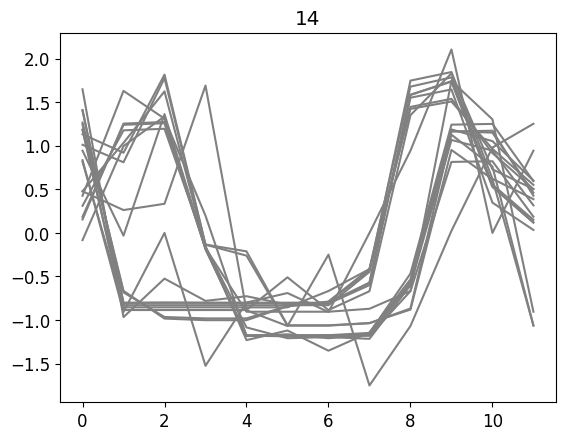

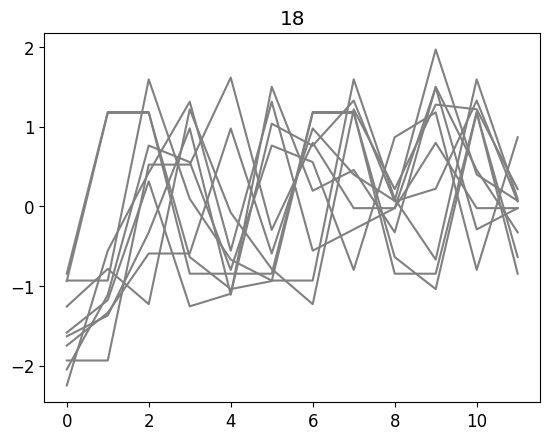

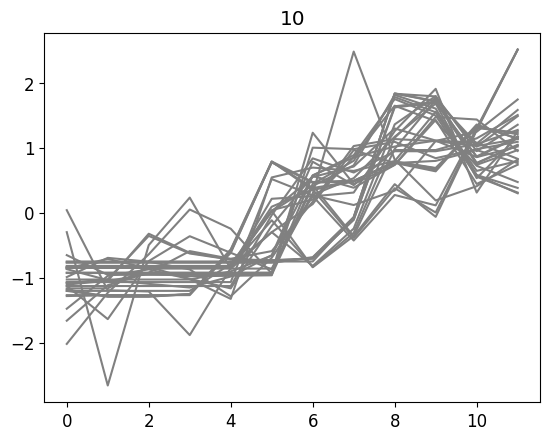

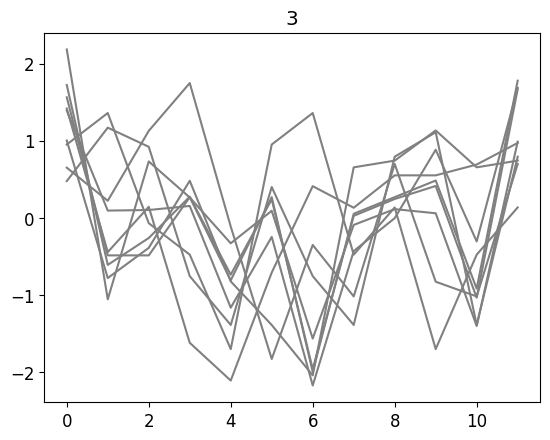

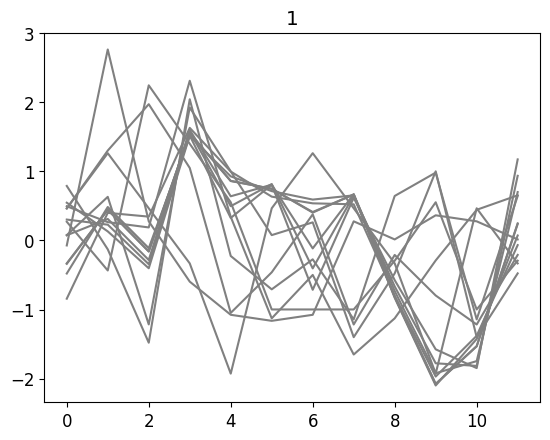

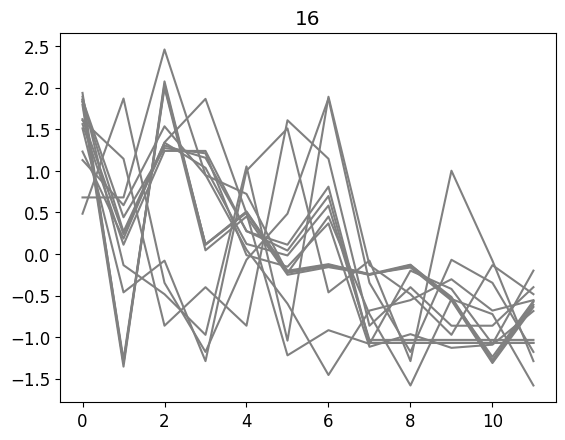

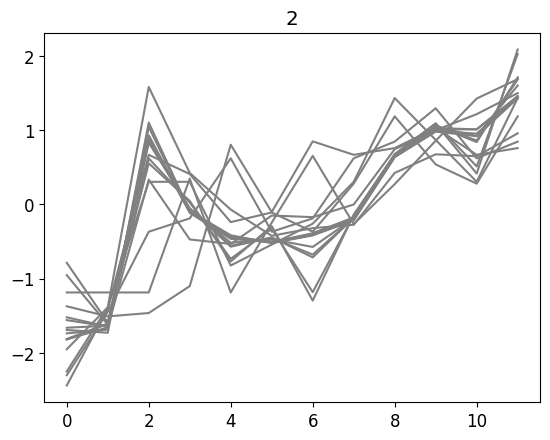

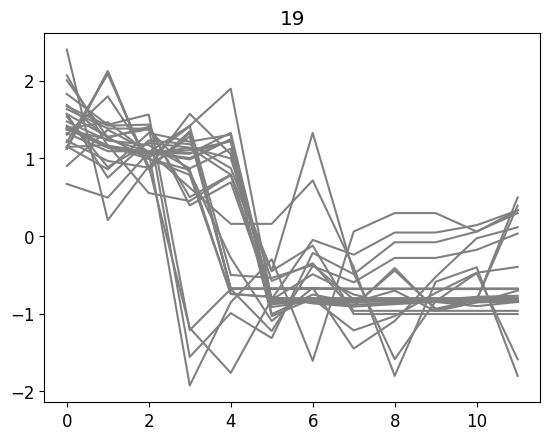

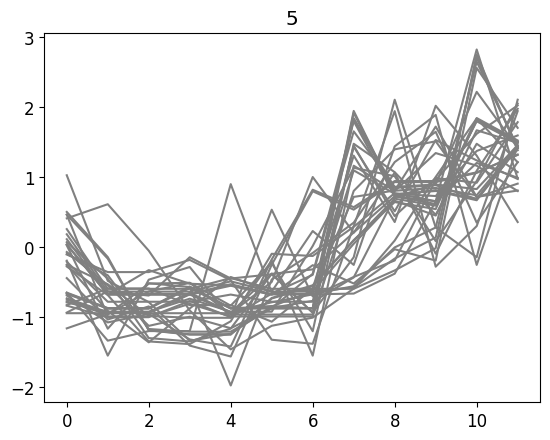

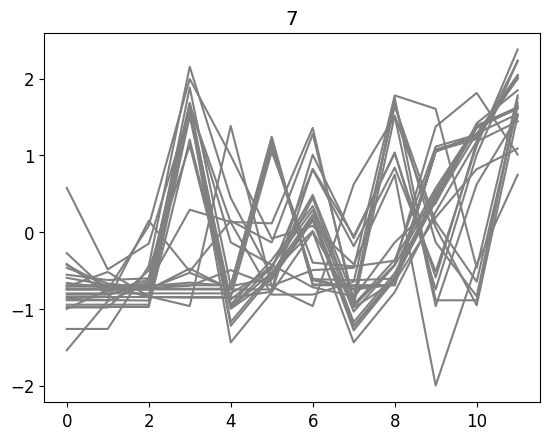

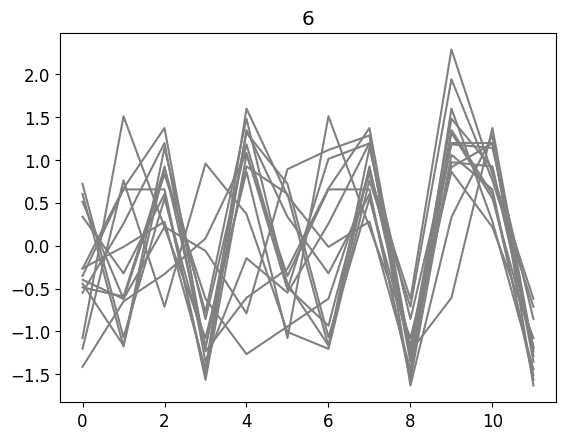

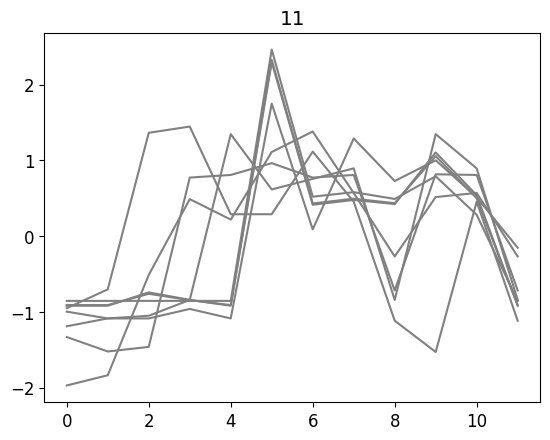

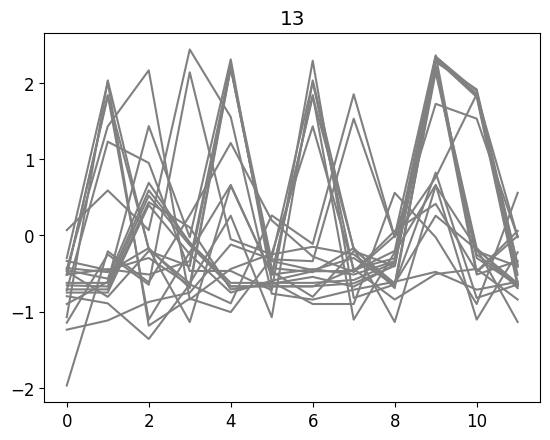

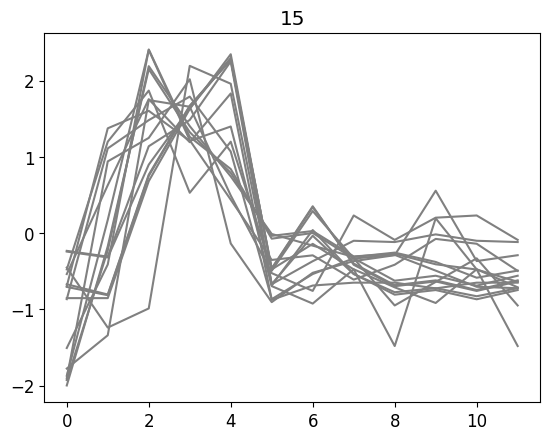

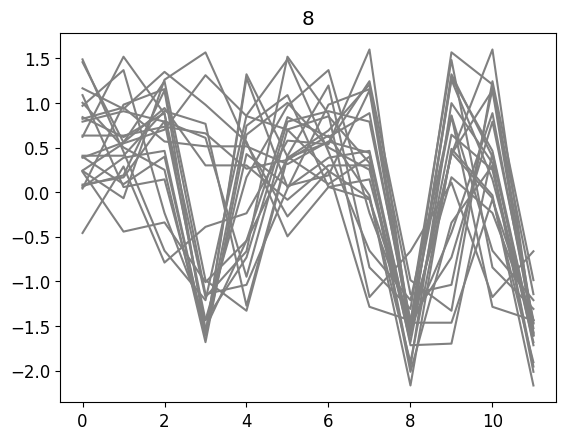

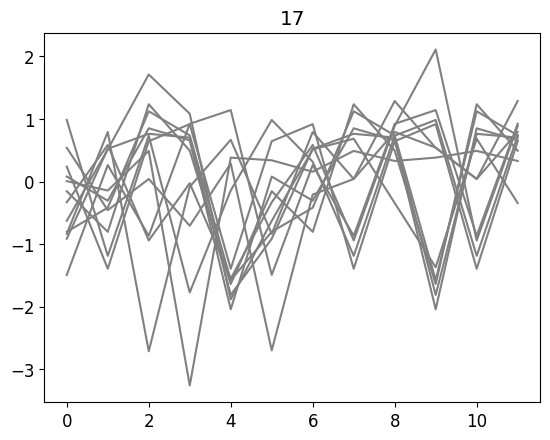

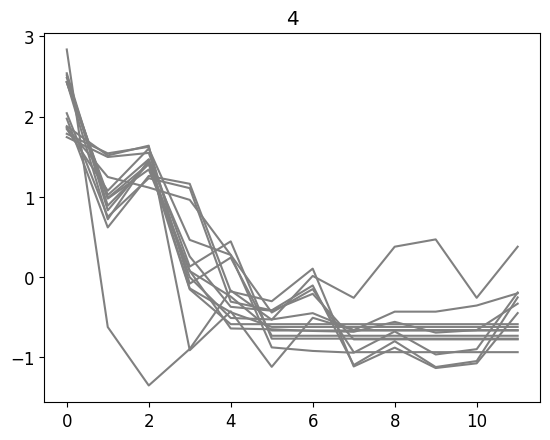

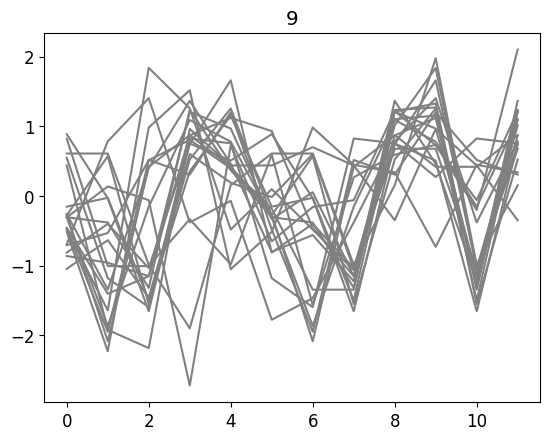

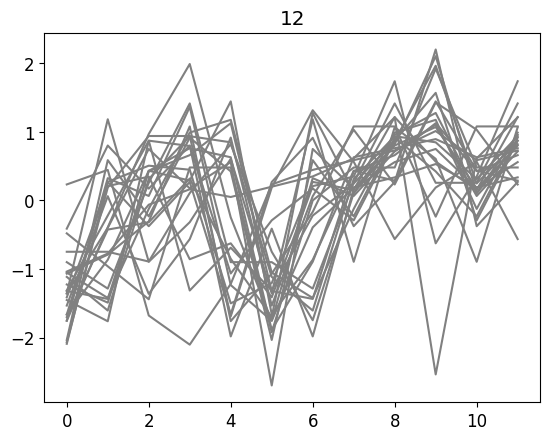

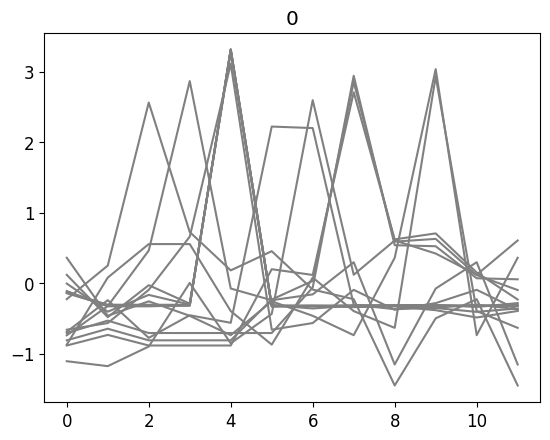

In [43]:
# VISUALIZING CLUSTER SHAPES FOR Z-SCORE NORMALIZATION
for i in range(len(tempz)):
  clus = int(znorm.loc[i]['clabels'])
  plt.figure(clus)
  plt.title(clus)
  plt.plot( tempz.T.index.values, tempz.T[i], color = 'gray')
  globals()[f"dfz{clus}"]= pd.concat([globals()[f"dfz{clus}"],tempz.T[i]],axis=1 )

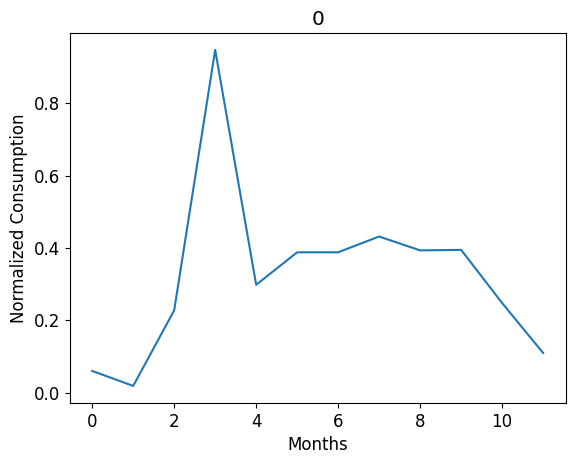

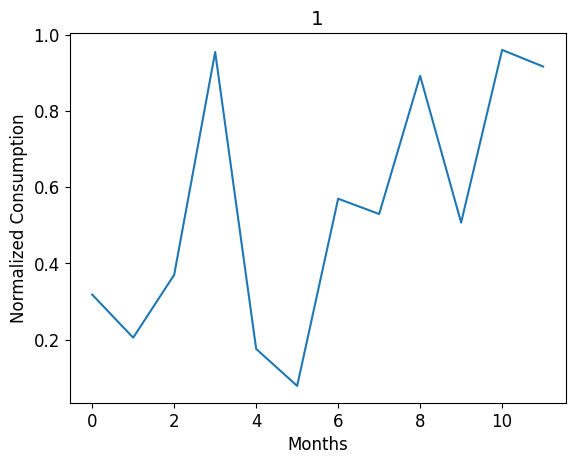

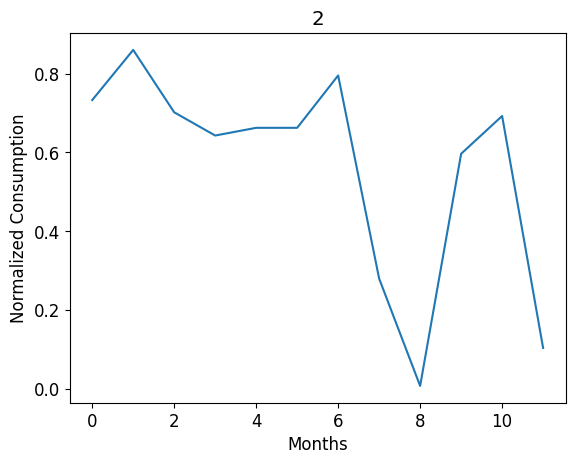

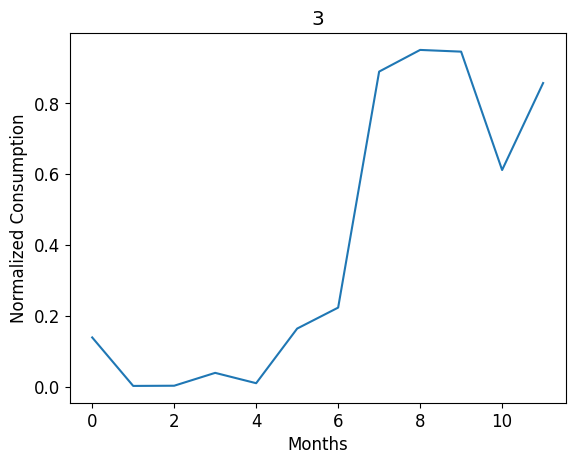

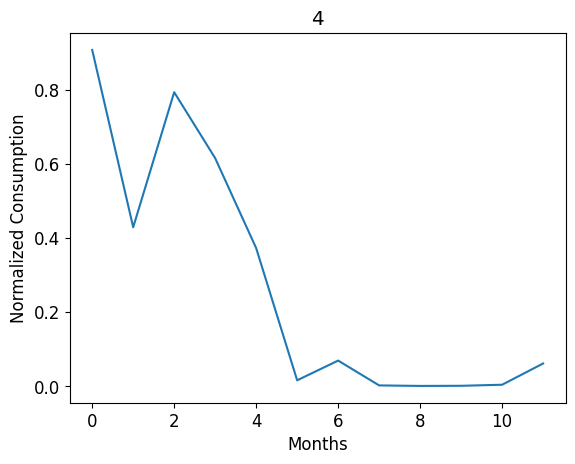

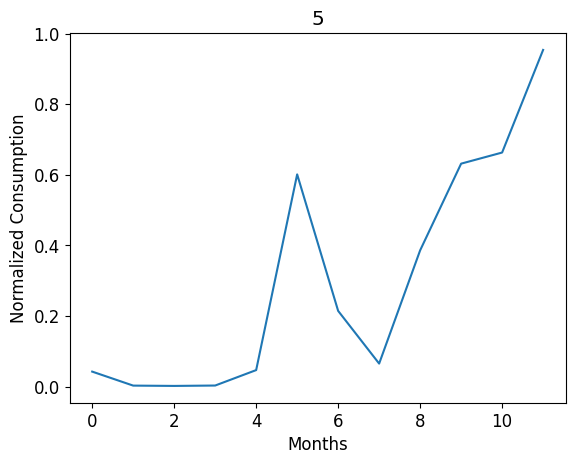

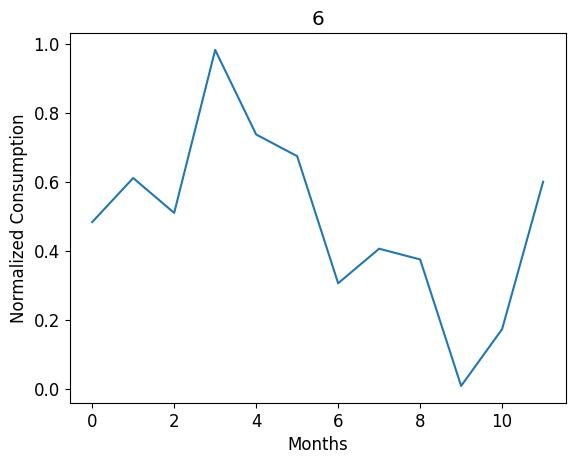

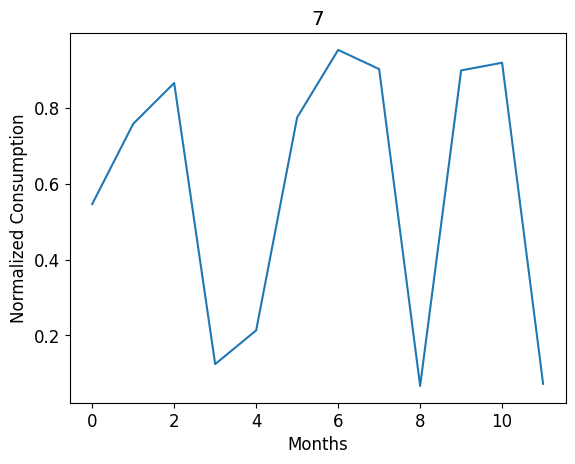

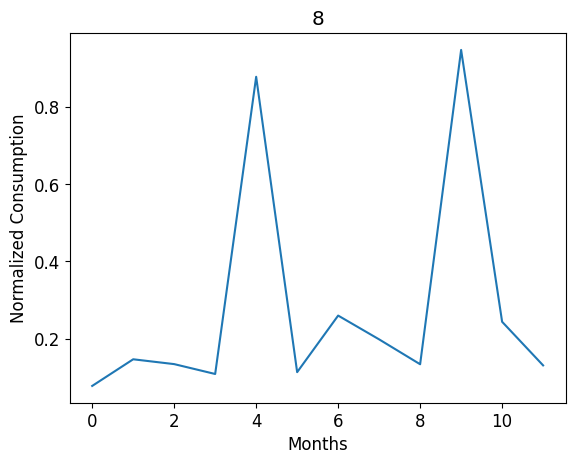

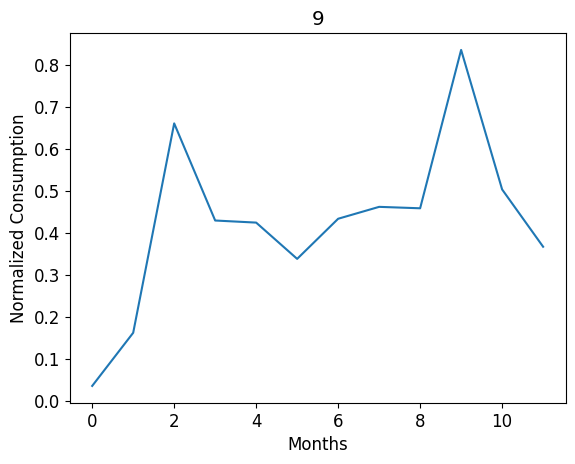

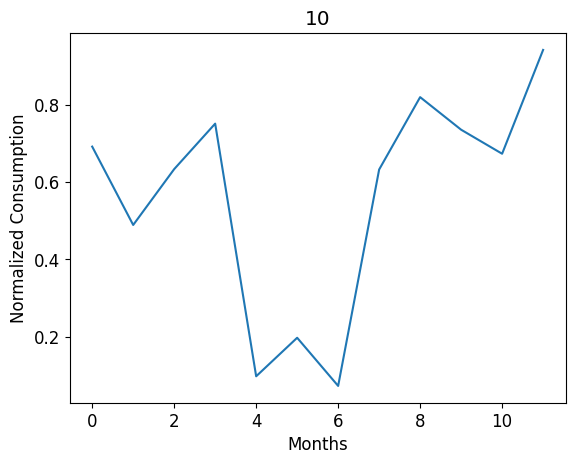

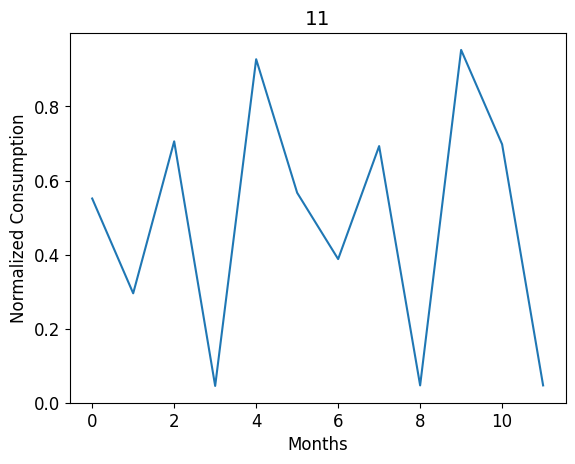

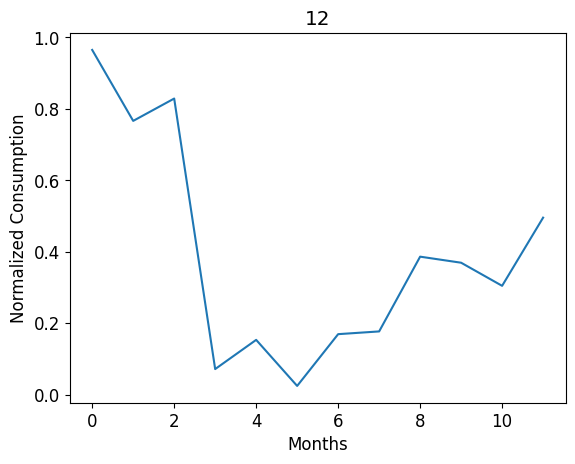

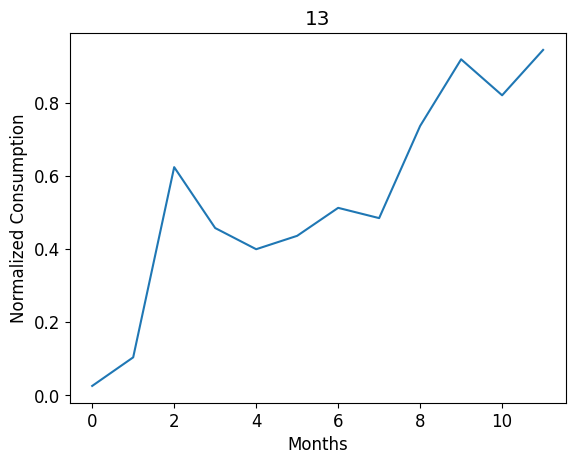

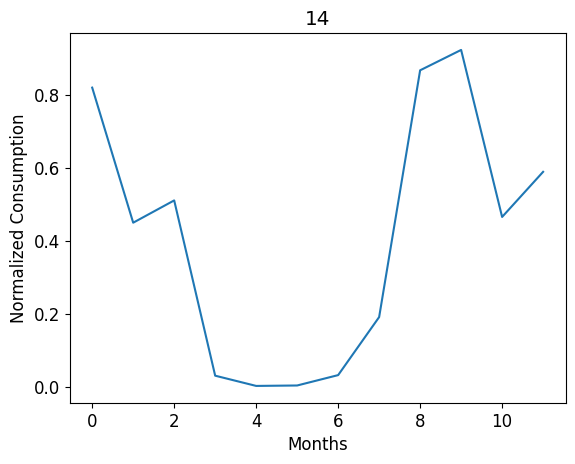

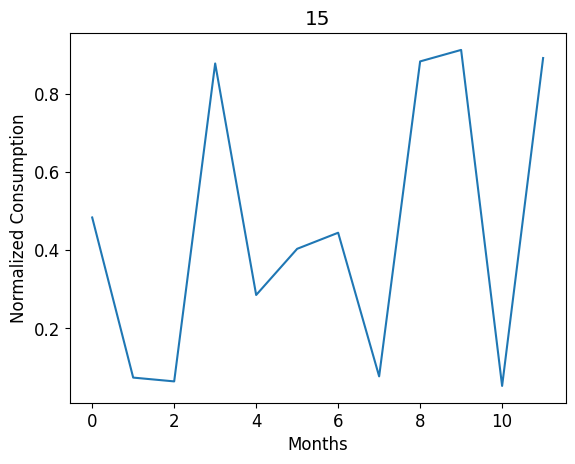

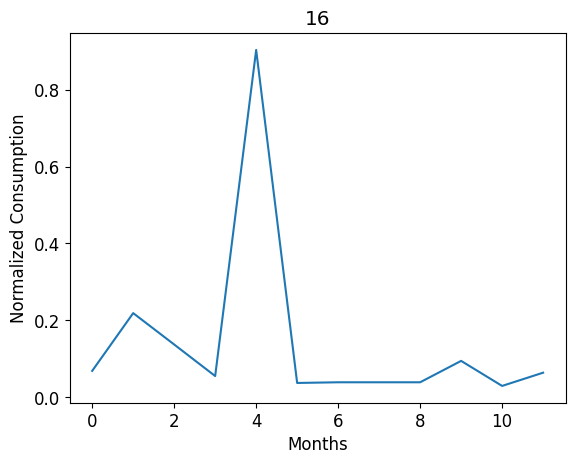

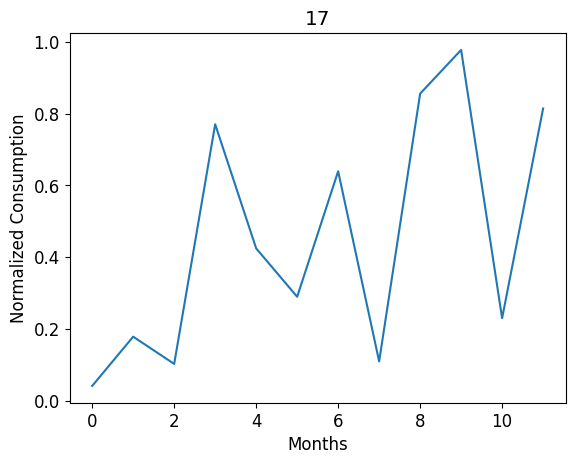

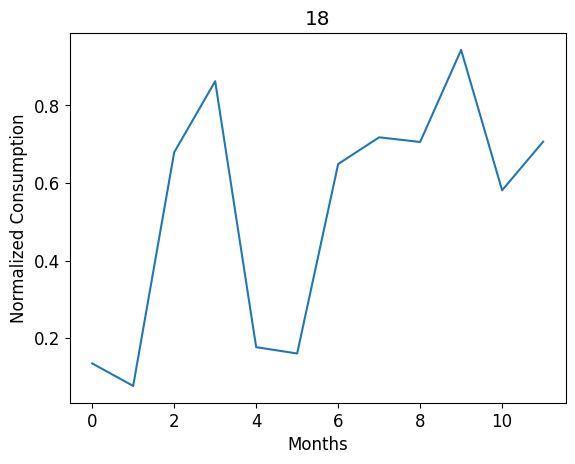

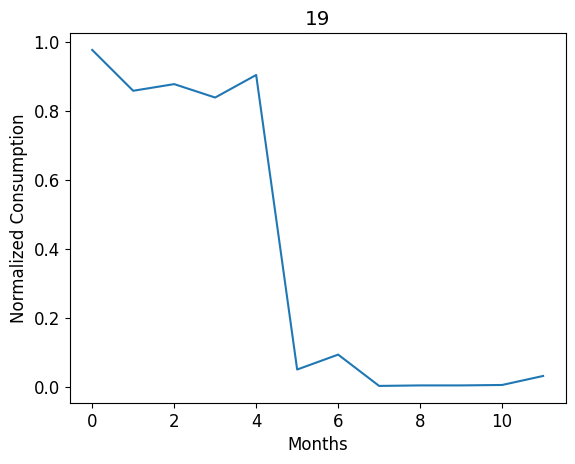

In [44]:
# VISUALIZING AVERAGE CLUSTER SHAPES FOR MINMAX-SCALING NORMALIZATION
for i in range(nums):
  average = dtw_barycenter_averaging((globals()[f"df{i}"]).T, max_iter=14)
  plt.figure(i)
  plt.title(i)
  plt.xlabel("Months")
  plt.ylabel("Normalized Consumption")
  plt.plot(average)

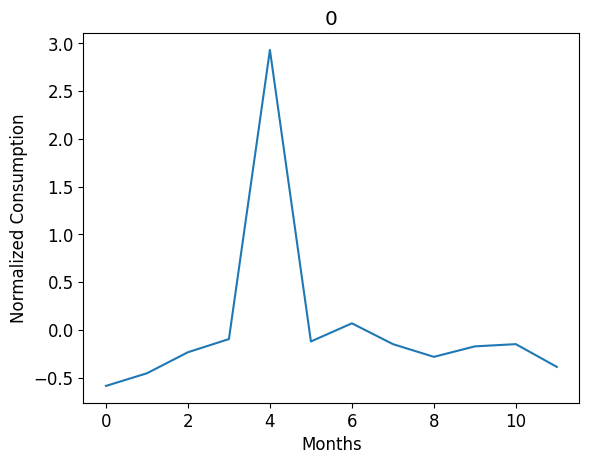

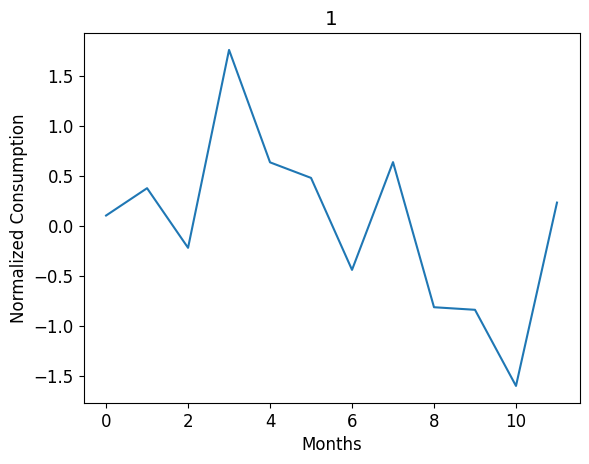

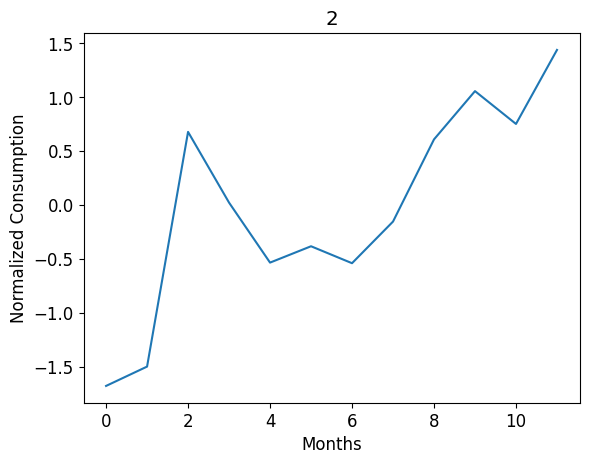

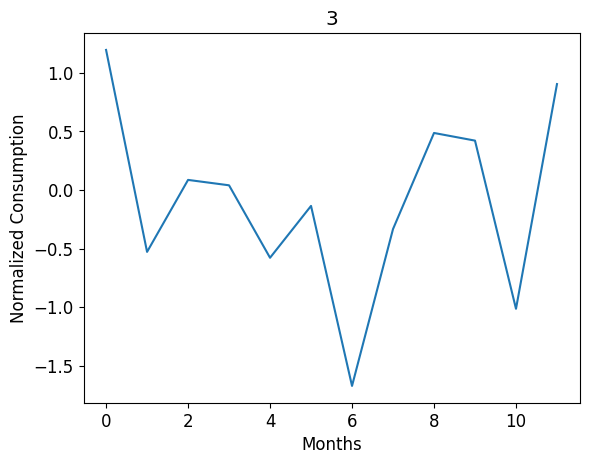

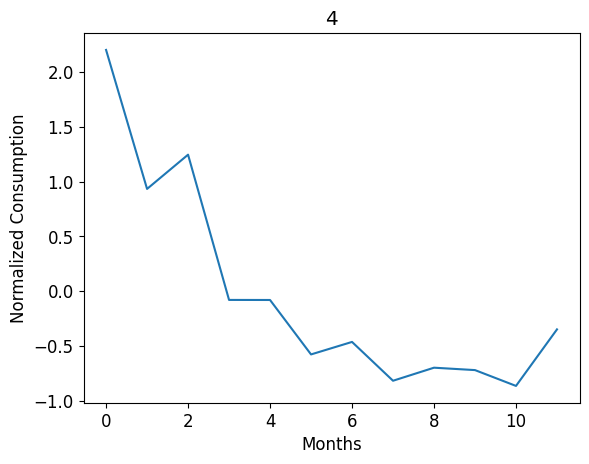

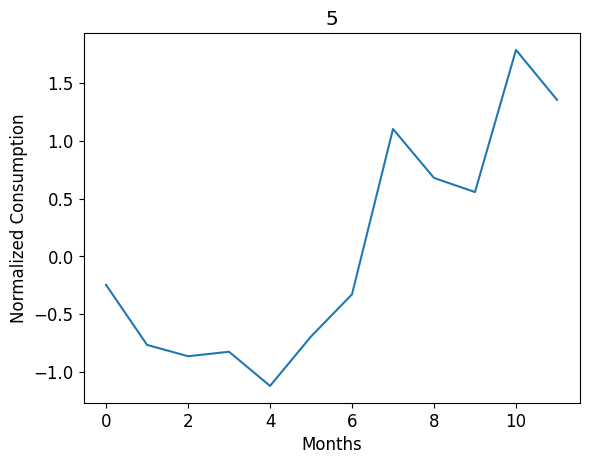

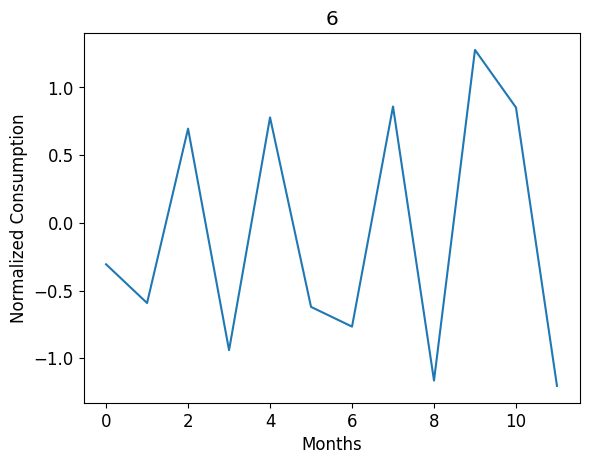

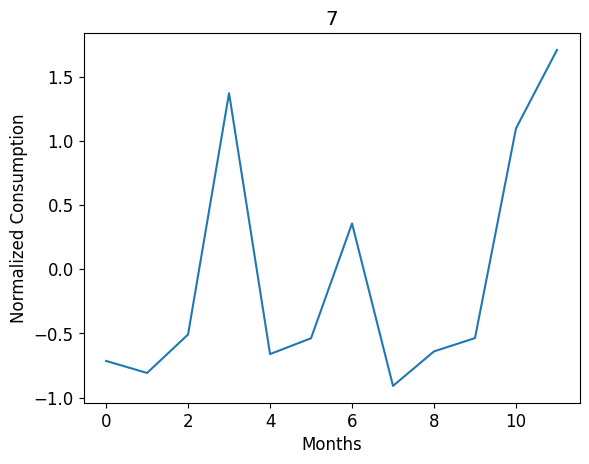

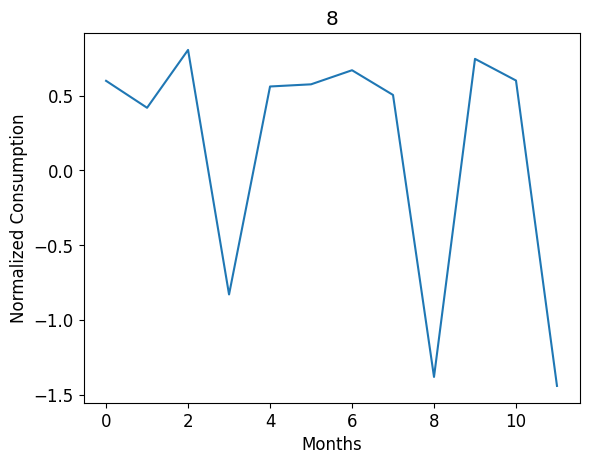

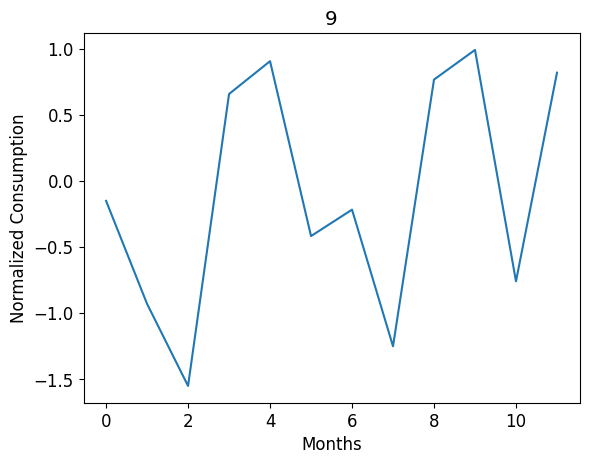

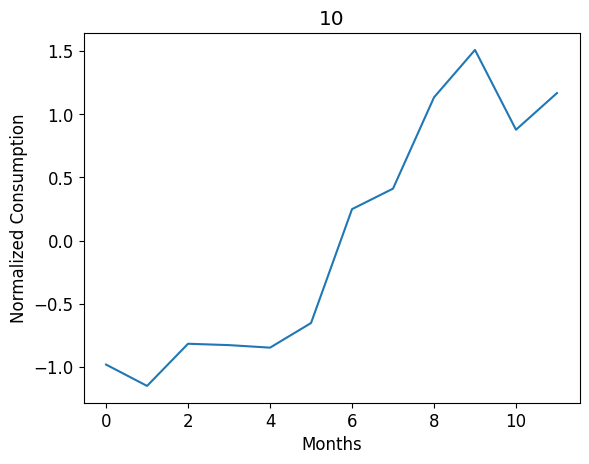

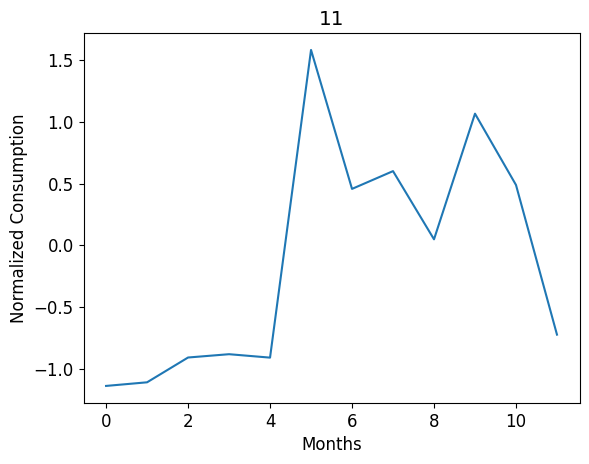

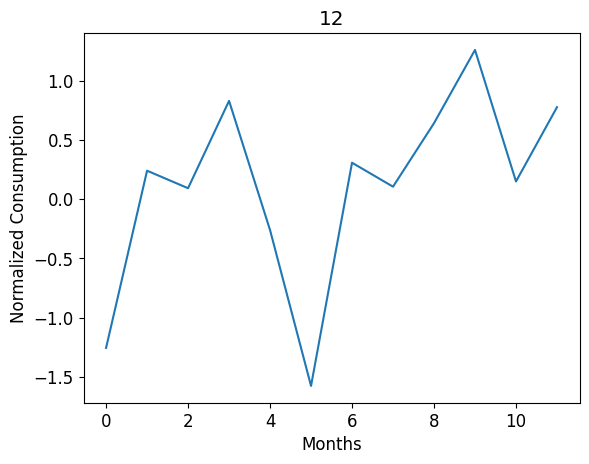

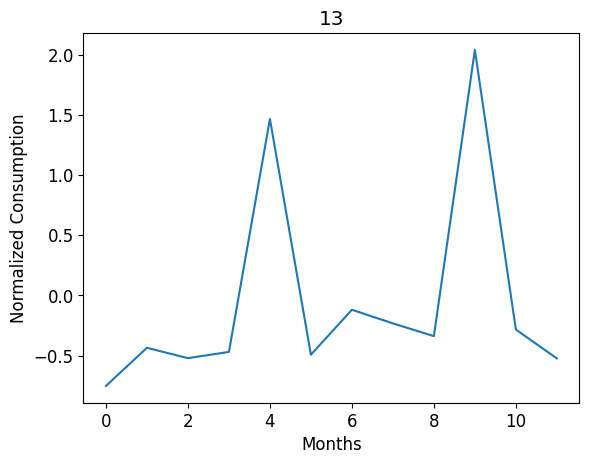

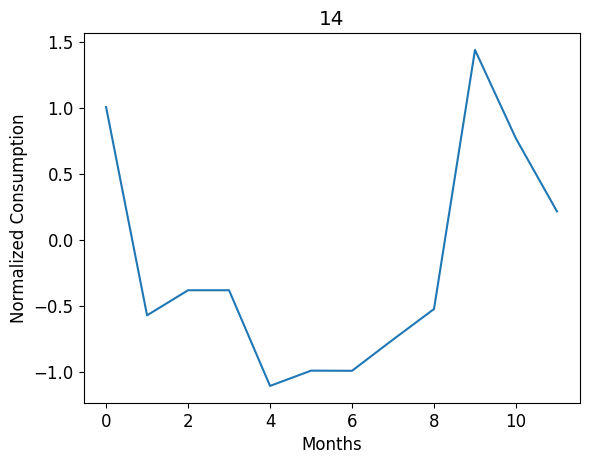

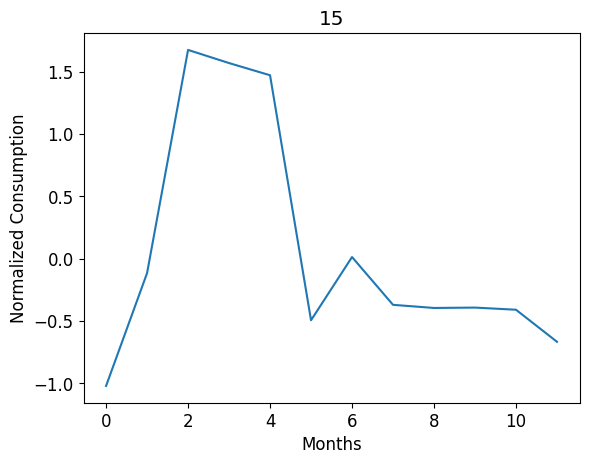

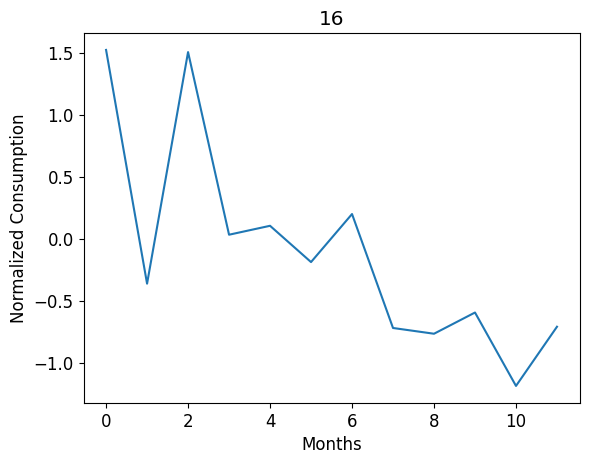

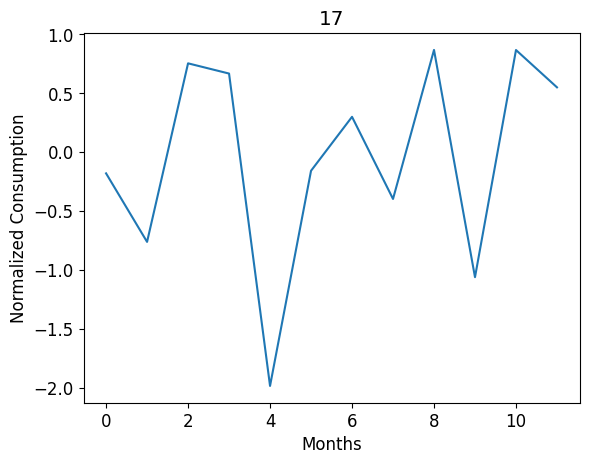

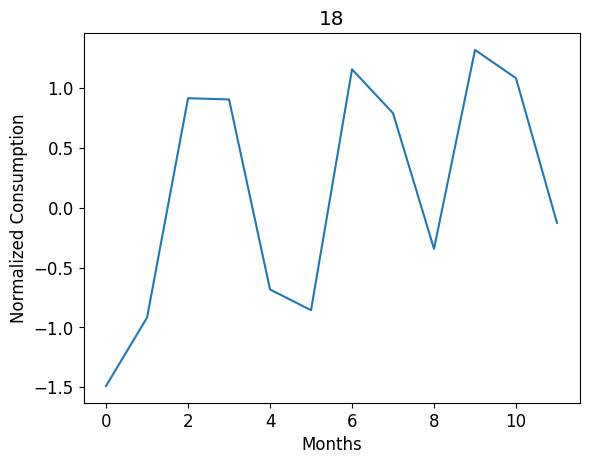

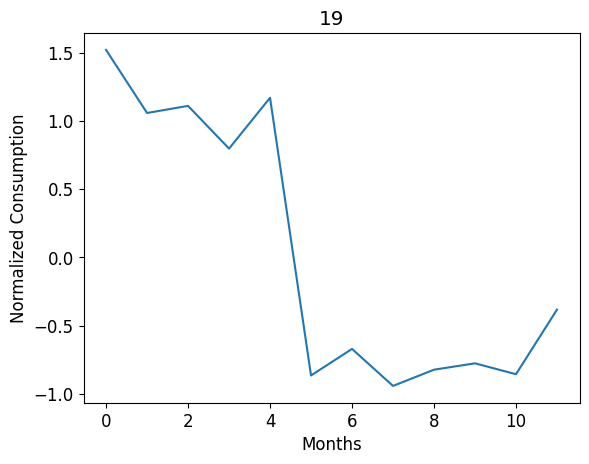

In [45]:
# VISUALIZING AVERAGE CLUSTER SHAPES FOR Z-SCORE NORMALIZATION
for i in range(nums):
  average = dtw_barycenter_averaging((globals()[f"dfz{i}"]).T, max_iter=14)
  plt.figure(i)
  plt.title(i)
  plt.xlabel("Months")
  plt.ylabel("Normalized Consumption")
  plt.plot(average)

### Finalizing of TRAINING DATA

In [46]:
y = X['label']
# TRAINING DATA FOR MINMAX NORMALIZATION
X_MM =X.drop(columns = ['label'])
# TRAINING DATA FOR Z-SCORE NORMALIZATION
X_ZS = X.drop(columns = ['label'])
X_ZS['clabels'] = labelz
X_MM['clabels'] = labels

In [47]:
X_ZS

cOfVar  peakMonth  minMonth  clabels
0    1.512002         11         0        7
1    1.124617          8         0       10
2    1.782401          0         4        4
3    1.402028         11         0        7
4    0.924856         11         0       10
..        ...        ...       ...      ...
369  0.064823          2         4       17
370  0.525796          0         2        4
371  0.222945          4         1        9
372  0.269542          9         5       12
373  1.055385          5         2        0

[374 rows x 4 columns]

In [48]:
X_MM

cOfVar  peakMonth  minMonth  clabels
0    1.512002         11         0        5
1    1.124617          8         0        9
2    1.782401          0         4        4
3    1.402028         11         0        5
4    0.924856         11         0       13
..        ...        ...       ...      ...
369  0.064823          2         4        1
370  0.525796          0         2       12
371  0.222945          4         1       15
372  0.269542          9         5        1
373  1.055385          5         2       16

[374 rows x 4 columns]

## FEATURE EXTRACTION OF TEST DATA

In [49]:
# TEST DATA FOR MINMAX NORMALIZATION
Xtest_MM = pd.DataFrame(scaler.fit_transform(X_test.T)).T
# TEST DATA FOR Z-SCORE NORMALIZATION
Xtest_ZS = pd.DataFrame(scale.fit_transform(X_test.T)).T

In [50]:
Xtest_ZS

0         1         2         3         4         5         6   \
0   -0.536945 -0.597057 -0.980276 -1.077960 -1.010333  0.413588  1.826238   
1   -0.283190  0.525924 -0.121367  0.849569  0.849569 -0.283190  1.496860   
2   -0.022425  0.515768  0.246671  0.623406 -2.175194 -2.175194 -0.022425   
3   -0.171860 -0.564683 -0.171860 -2.135974 -0.761094  1.301226  0.122757   
4    0.114971  0.509155  0.706248 -0.082122 -2.053046 -2.053046  0.114971   
..        ...       ...       ...       ...       ...       ...       ...   
139 -0.666744 -0.768021 -0.413550 -1.021215 -1.527603 -0.666744 -0.312272   
140  0.516627 -1.136580 -0.861046 -1.549882  1.205464  1.205464  1.343231   
141  0.183505  1.713752 -2.055881 -1.160126  0.034213  0.183505  1.713752   
142  0.949556  1.020002  1.847744  1.689240 -0.688318 -0.688318 -0.688318   
143 -1.419871  0.159536  1.308196 -0.414794 -1.036985  1.308196 -0.414794   

           7         8         9         10        11  
0    1.818724  0.868191  0.173137 -0.123669 -0.773639  
1   -1.901416  0.525924 -0.283190 -1.901416  0.525924  
2    0.623406  0.623406  0.515768  0.623406  0.623406  
3   -0.564683  1.104814  1.301226 -0.564683  1.104814  
4    0.114971  0.509155  1.494618  0.114971  0.509155  
..        ...       ...       ...       ...       ...  
139  1.257529  0.548587  1.763917  1.257529  0.548587  
140 -0.172209  0.516627 -1.412115 -0.172209  0.516627  
141  0.146182 -0.469649  0.034213  0.146182 -0.469649  
142 -0.688318 -0.688318 -0.688318 -0.688318 -0.688318  
143  1.212474 -1.036985  0.159536  1.212474 -1.036985  

[144 rows x 12 columns]

In [51]:
Xtest_MM

0         1         2         3         4         5         6   \
0    0.186287  0.165589  0.033635  0.000000  0.023286  0.513583  1.000000   
1    0.476190  0.714286  0.523810  0.809524  0.809524  0.476190  1.000000   
2    0.769231  0.961538  0.865385  1.000000  0.000000  0.000000  0.769231   
3    0.571429  0.457143  0.571429  0.000000  0.400000  1.000000  0.657143   
4    0.611111  0.722222  0.777778  0.555556  0.000000  0.000000  0.611111   
..        ...       ...       ...       ...       ...       ...       ...   
139  0.261538  0.230769  0.338462  0.153846  0.000000  0.261538  0.369231   
140  0.714286  0.142857  0.238095  0.000000  0.952381  0.952381  1.000000   
141  0.594059  1.000000  0.000000  0.237624  0.554455  0.594059  1.000000   
142  0.645833  0.673611  1.000000  0.937500  0.000000  0.000000  0.000000   
143  0.000000  0.578947  1.000000  0.368421  0.140351  1.000000  0.368421   

           7         8         9         10        11  
0    0.997413  0.670116  0.430789  0.328590  0.104787  
1    0.000000  0.714286  0.476190  0.000000  0.714286  
2    1.000000  1.000000  0.961538  1.000000  1.000000  
3    0.457143  0.942857  1.000000  0.457143  0.942857  
4    0.611111  0.722222  1.000000  0.611111  0.722222  
..        ...       ...       ...       ...       ...  
139  0.846154  0.630769  1.000000  0.846154  0.630769  
140  0.476190  0.714286  0.047619  0.476190  0.714286  
141  0.584158  0.420792  0.554455  0.584158  0.420792  
142  0.000000  0.000000  0.000000  0.000000  0.000000  
143  0.964912  0.140351  0.578947  0.964912  0.140351  

[144 rows x 12 columns]

In [52]:
std_mm = X_test.T.std()
mean_mm = X_test.T.mean()
# TEST DATA FOR MINMAX NORMALIZATION
features_test = pd.concat([std_mm, mean_mm], axis = 1)
features_test["cOfVar"] = features_test[0]/features_test[1]
features_test.drop(columns=[0,1], inplace= True)
features_test['peakMonth'] = X_test.T.idxmax().to_numpy()
features_test['minMonth'] = X_test.T.idxmin().to_numpy()

# TEST DATA FOR Z-SCORE NORMALIZATION
features_testz = pd.DataFrame.copy(features_test)
new_p = kms.predict(Xtest_MM)
new_z= kmz.predict(Xtest_ZS)
features_test['clabels'] = new_p
features_testz['clabels'] = new_z
print(features_test)
print(features_testz)

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 144 1-dimensional timeseries
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 144 1-dimensional timeseries
  warnings.warn(


       cOfVar  peakMonth  minMonth  clabels
25   0.535735          6         3        9
300  0.385336          6         7        6
119  0.384931          3         4       10
241  0.140403          5         3       10
173  0.105111          9         4       10
..        ...        ...       ...      ...
43   0.145082          9         4        3
35   0.288814          6         3       14
5    0.177023          1         2       14
13   1.517418          2         4       19
186  0.124941          2         0        7

[144 rows x 4 columns]
       cOfVar  peakMonth  minMonth  clabels
25   0.535735          6         3       15
300  0.385336          6         7        1
119  0.384931          3         4       12
241  0.140403          5         3        9
173  0.105111          9         4       12
..        ...        ...       ...      ...
43   0.145082          9         4        5
35   0.288814          6         3        9
5    0.177023          1         2       14
13   1.5

In [53]:
# TRAINING DATA FOR MINMAX NORMALIZATION
X_MM, y_m = shuffle(X_MM, y, random_state=random_state)
# TRAINING DATA FOR Z-SCORE NORMALIZATION
X_ZS, y_s = shuffle(X_ZS, y, random_state=random_state)

In [54]:
y_s

161    1
178    1
132    1
98     1
208    0
      ..
343    0
359    0
323    0
280    0
8      1
Name: label, Length: 374, dtype: int64

In [55]:
X_MM

cOfVar  peakMonth  minMonth  clabels
161  1.064633          9         3       14
178  0.059391          0         6       12
132  1.527099          1         4        4
98   1.542222         10         1        9
208  0.111963          9         0       17
..        ...        ...       ...      ...
343  0.066121          2         4       18
359  0.226409          9         2        3
323  0.422447          7         8        7
280  0.126138          9         1        3
8    1.477954          7         0        0

[374 rows x 4 columns]

## TESTING AND EVALUATION

In [56]:
# Models for comparison
svc_MM = SVC()
svc_ZS  = SVC()
xgb_MM = xgb.XGBClassifier()
xgb_ZS = xgb.XGBClassifier()
lgb_MM = lgb.LGBMClassifier()
lgb_ZS = lgb.LGBMClassifier()

# Models for raw time-series
svc_mm = SVC()
svc_zs  = SVC()
xgb_mm = xgb.XGBClassifier()
xgb_zs = xgb.XGBClassifier()
lgb_mm = lgb.LGBMClassifier()
lgb_zs = lgb.LGBMClassifier()

In [57]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

        # Make predictions on the test data
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)


### SVC Comparison

**MIN-MAX NORMALIZATION**

In [58]:
# Hyperparameter Tuning
C= [ 1,10,15,20,25,30,100,1000]
kernel = ['rbf', 'linear']
param_grid = dict(C = C,kernel = kernel)
searcher_SVC_MM = GridSearchCV(svc_MM, n_jobs=-1, cv=5,
	param_grid=param_grid, scoring='accuracy')
searchResults_SVC_MM = searcher_SVC_MM .fit(X_MM , y_m)

In [59]:
print(searchResults_SVC_MM.best_score_)
print(searchResults_SVC_MM.best_params_)

0.9091171171171171
{'C': 100, 'kernel': 'rbf'}


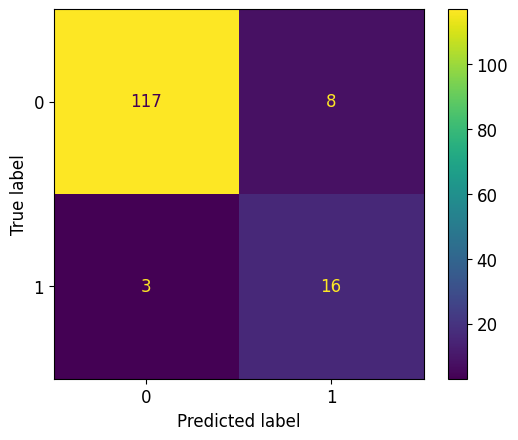

In [60]:
svc_MM = searchResults_SVC_MM.best_estimator_
y_pred = svc_MM.predict(features_test)
cm_t = confusion_matrix(y_test, y_pred, labels=svc_MM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=svc_MM.classes_)
disp.plot()

In [61]:
accuracy_SVC_MM= accuracy_score(y_test, y_pred)
f1_SVC_MM= f1_score(y_test, y_pred)
print(f'F1 = {f1_SVC_MM}, accuracy = {accuracy_SVC_MM}')

F1 = 0.744186046511628, accuracy = 0.9236111111111112


**Z-SCORE NORMALIZATION**

In [62]:
C= [ 1,10,15,20,25,30,100,1000]
kernel = ['rbf', 'linear']
param_grid = dict(C = C,kernel = kernel)
searcher_SVC_ZS = GridSearchCV(svc_ZS, n_jobs=-1, cv=5,
	param_grid=param_grid, scoring='accuracy')
searchResults_SVC_ZS = searcher_SVC_ZS.fit(X_ZS, y_s)

In [63]:
print(searchResults_SVC_ZS.best_score_)
print(searchResults_SVC_ZS.best_params_)

0.9011531531531531
{'C': 1000, 'kernel': 'rbf'}


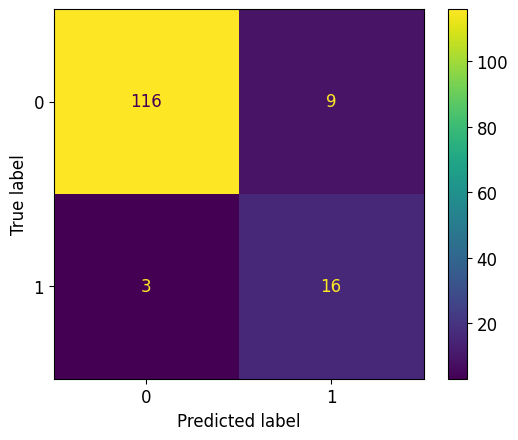

In [64]:
svc_ZS = searchResults_SVC_ZS.best_estimator_
y_pred = svc_ZS.predict(features_testz)
cm_t = confusion_matrix(y_test, y_pred, labels=svc_MM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=svc_MM.classes_)
disp.plot()

In [65]:
accuracy_SVC_ZS = accuracy_score(y_test, y_pred)
f1_SVC_ZS = f1_score(y_test, y_pred)
print(f'F1 = {f1_SVC_ZS}, accuracy = {accuracy_SVC_ZS}')

F1 = 0.7272727272727272, accuracy = 0.9166666666666666


### XGBoost Comparison

MIN-MAX NORMALIZATION

In [96]:
xgb_params = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.5, 0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 5, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}
searcher_xgb_MM = GridSearchCV(xgb_MM, n_jobs=-1, cv=3,
	param_grid=xgb_params, scoring="accuracy")
searchResults_xgb_MM  = searcher_xgb_MM .fit(X_MM, y_m)

In [67]:
print(searchResults_xgb_MM .best_score_)
print(searchResults_xgb_MM .best_params_)

0.9519139784946237
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 1, 'scale_pos_weight': 3, 'subsample': 0.8}


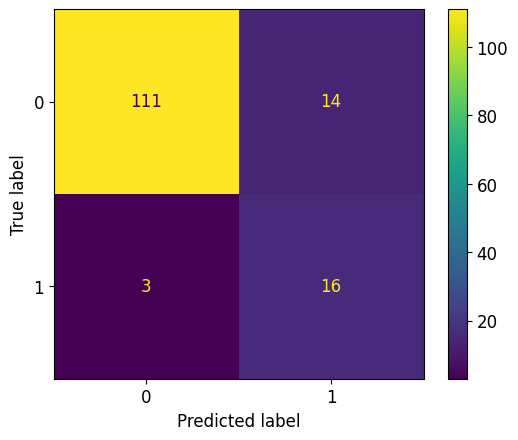

In [68]:
xgb_MM = searchResults_xgb_MM.best_estimator_
y_pred = xgb_MM.predict(features_test)
cm_t = confusion_matrix(y_test, y_pred, labels=svc_MM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=svc_MM.classes_)
disp.plot()

In [69]:
accuracy_xgb_MM = accuracy_score(y_test, y_pred)
f1_xgb_MM = f1_score(y_test, y_pred)
print(f'F1 = {f1_xgb_MM}, accuracy = {accuracy_xgb_MM}')

F1 = 0.653061224489796, accuracy = 0.8819444444444444


**Z-SCORE NORMALIZATION**

In [70]:
xgb_params = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 5, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}
searcher_xgb_ZS = GridSearchCV(xgb_ZS, n_jobs=-1, cv=3,
	param_grid=xgb_params, scoring="accuracy")
searchResults_xgb_ZS = searcher_xgb_ZS.fit(X_ZS, y_s)

In [71]:
print(searchResults_xgb_ZS.best_score_)
print(searchResults_xgb_ZS.best_params_)

0.9599139784946237
{'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 7, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.8}


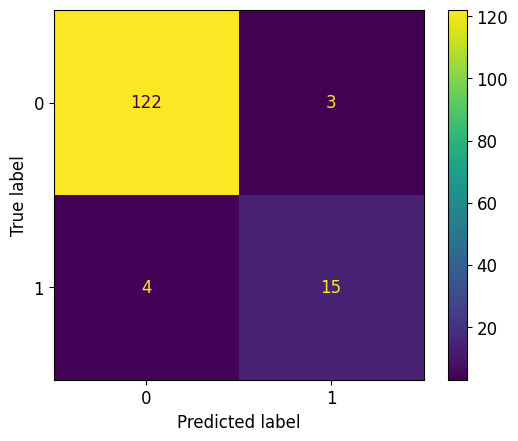

In [72]:
xgb_ZS = searchResults_xgb_ZS.best_estimator_
y_pred = xgb_ZS.predict(features_testz)
cm_t = confusion_matrix(y_test, y_pred, labels=svc_MM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=svc_MM.classes_)
disp.plot()

In [73]:
accuracy_xgb_ZS = accuracy_score(y_test, y_pred)
f1_xgb_ZS = f1_score(y_test, y_pred)
print(f'F1 = {f1_xgb_ZS}, accuracy = {accuracy_xgb_ZS}')

F1 = 0.8108108108108109, accuracy = 0.9513888888888888


### LGBM Comparison

In [ ]:
lgbm_params = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    'num_leaves' : [5,10,20]
}
searcher_lgbm_MM  = GridSearchCV(lgb_MM, n_jobs=-1, cv=5,
	param_grid=lgbm_params, scoring="accuracy")
searchResults_lgbm_MM  = searcher_lgbm_MM.fit(X_MM, y_m)

In [75]:
print(searchResults_lgbm_MM .best_score_)
print(searchResults_lgbm_MM .best_params_)

0.9546306306306308
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 10, 'reg_lambda': 1, 'scale_pos_weight': 3, 'subsample': 0.8}


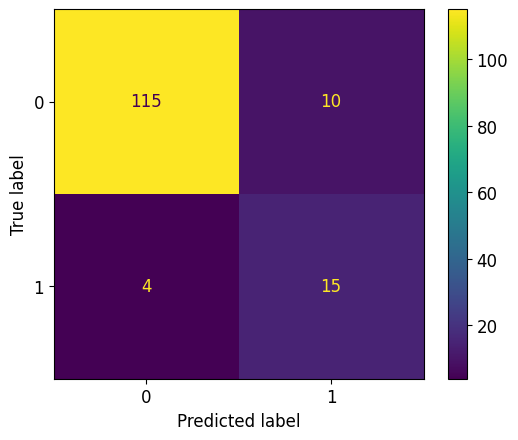

In [76]:
lgb_MM = searchResults_lgbm_MM.best_estimator_
y_pred = xgb_ZS.predict(features_test)
cm_t = confusion_matrix(y_test, y_pred, labels=svc_MM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=svc_MM.classes_)
disp.plot()

In [77]:
accuracy_lgbm_MM= accuracy_score(y_test, y_pred)
f1_lgbm_MM= f1_score(y_test, y_pred)
print(f'F1 = {f1_lgbm_MM}, accuracy = {accuracy_lgbm_MM}')

F1 = 0.6818181818181819, accuracy = 0.9027777777777778


In [ ]:
lgbm_params = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    'num_leaves' : [5,10,20]
}
searcher_lgbm_ZS = GridSearchCV(lgb_MM, n_jobs=-1, cv=5,
	param_grid=lgbm_params, scoring="accuracy")
searchResults_lgbm_ZS = searcher_lgbm_ZS.fit(X_ZS, y_s)

In [79]:
print(searchResults_lgbm_ZS.best_score_)
print(searchResults_lgbm_ZS.best_params_)

0.9466306306306308
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 20, 'reg_lambda': 0, 'scale_pos_weight': 3, 'subsample': 0.8}


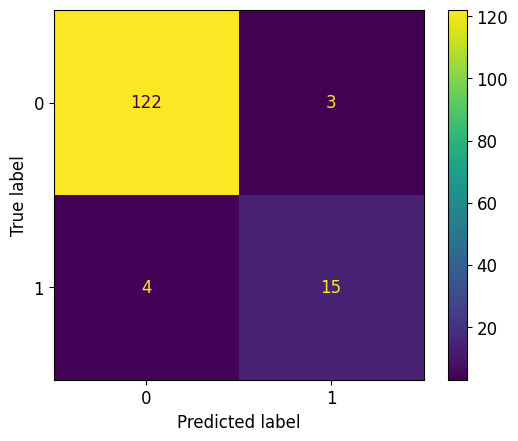

In [80]:
lgb_ZS = searchResults_lgbm_ZS.best_estimator_
y_pred = xgb_ZS.predict(features_testz)
cm_t = confusion_matrix(y_test, y_pred, labels=svc_MM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=svc_MM.classes_)
disp.plot()

In [81]:
accuracy_lgbm_ZS= accuracy_score(y_test, y_pred)
f1_lgbm_ZS= f1_score(y_test, y_pred)
print(f'F1 = {f1_lgbm_ZS}, accuracy = {accuracy_lgbm_ZS}')

F1 = 0.8108108108108109, accuracy = 0.9513888888888888


In [82]:
# ACCURACY DF
acc_dict = {
  'accuracy' : [accuracy_SVC_MM, accuracy_SVC_ZS, accuracy_xgb_MM, accuracy_xgb_ZS, accuracy_lgbm_MM, accuracy_lgbm_ZS ] ,
  'Model' : ['SVC_MM', 'SVC_ZS', 'xgb_MM', 'xgb_ZS', 'lgbm_MM', 'lgbm_ZS' ]
}
acc_df = pd.DataFrame(acc_dict)
print(acc_df)

   accuracy    Model
0  0.923611   SVC_MM
1  0.916667   SVC_ZS
2  0.881944   xgb_MM
3  0.951389   xgb_ZS
4  0.902778  lgbm_MM
5  0.951389  lgbm_ZS


In [83]:
# ACCURACY DF
f1_dict = {
  'accuracy' : [f1_SVC_MM, f1_SVC_ZS, f1_xgb_MM, f1_xgb_ZS, f1_lgbm_MM, f1_lgbm_ZS ] ,
  'Model' : ['SVC_MM', 'SVC_ZS', 'xgb_MM', 'xgb_ZS', 'lgbm_MM', 'lgbm_ZS' ]
}
f1_df = pd.DataFrame(acc_dict)
print(acc_df)

   accuracy    Model
0  0.923611   SVC_MM
1  0.916667   SVC_ZS
2  0.881944   xgb_MM
3  0.951389   xgb_ZS
4  0.902778  lgbm_MM
5  0.951389  lgbm_ZS


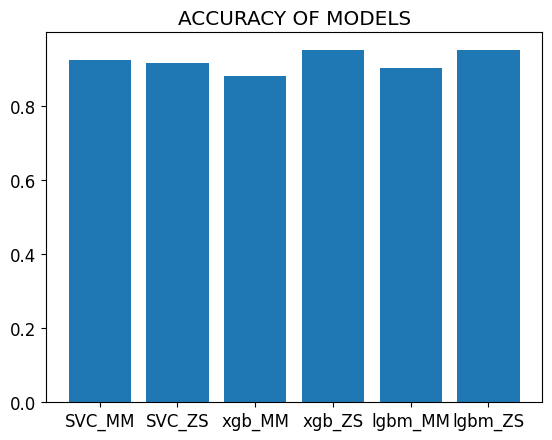

In [84]:
plt.bar(acc_df['Model'],acc_df['accuracy'])
plt.title('ACCURACY OF MODELS')
plt.show()

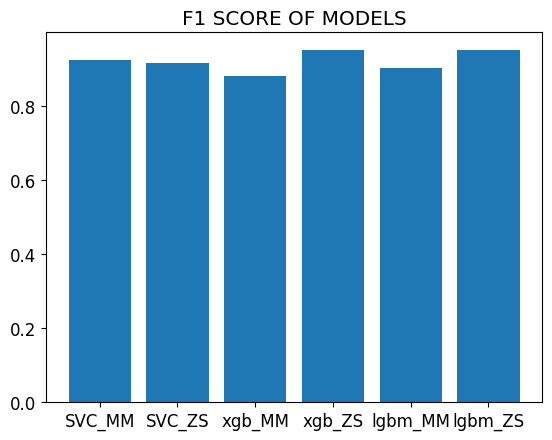

In [85]:
plt.bar(f1_df['Model'],f1_df['accuracy'])
plt.title('F1 SCORE OF MODELS')
plt.show()

## EVALUATION WITH TIMESERIES DATA

In [86]:
X_train

0           1           2           3           4           5  \
0     17.000000   20.000000   15.000000   13.000000   50.000000   17.000000   
1     99.000000  105.000000   45.000000   33.000000   58.000000   99.000000   
2     18.000000   15.000000   19.000000   10.000000   82.000000   18.000000   
3    220.000000  226.000000  273.000000  259.000000  143.000000  266.000000   
4     22.000000   29.000000   63.000000   36.000000   28.000000   32.000000   
..          ...         ...         ...         ...         ...         ...   
369   66.819802    0.000000    0.000000    0.000000   11.993298    0.000000   
370    4.037392    0.000000    0.000000    5.652348    0.000000   12.128866   
371    0.000000    0.000000    0.000000    6.590120    0.000000   44.798716   
372   38.532788   17.974149   26.896597   12.403534    4.870746    4.286256   
373    4.936871    0.000000    0.000000    6.911619    0.000000    0.795427   

              6           7           8           9          10          11  \
0     13.000000   38.000000   52.000000   13.000000   38.000000   52.000000   
1    105.000000  109.000000  113.000000  121.000000  109.000000  113.000000   
2     15.000000   19.000000   10.000000   82.000000   19.000000   10.000000   
3    277.000000  238.000000   68.000000  288.000000  238.000000   68.000000   
4     24.000000   22.000000    4.000000   18.000000   22.000000    4.000000   
..          ...         ...         ...         ...         ...         ...   
369    0.000000    4.730084   38.476923   63.033511  272.459406  166.953085   
370    0.000000   51.678612   29.876698   41.657912   40.198085   58.930780   
371    3.451968    0.000000    1.569076   43.192130   48.819760   67.288195   
372    6.819044    0.000000    0.000000    0.000000    0.000000    0.000000   
373    0.000000   63.191947   36.532844   38.239891   35.340897   52.454530   

     label  
0        0  
1        0  
2        0  
3        0  
4        0  
..     ...  
369      1  
370      1  
371      1  
372      1  
373      1  

[374 rows x 13 columns]

In [87]:
# Models for comparison
xgb_raw = xgb.XGBClassifier()

In [88]:
xgb_params = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}
searcher = GridSearchCV(xgb_raw, n_jobs=-1, cv=3,
	param_grid=xgb_params, scoring="accuracy")
searchResults = searcher.fit(train, y_train)


In [89]:
print(searchResults.best_score_)
print(searchResults.best_params_)

0.9491827956989246
{'colsample_bytree': 0.5, 'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.8}


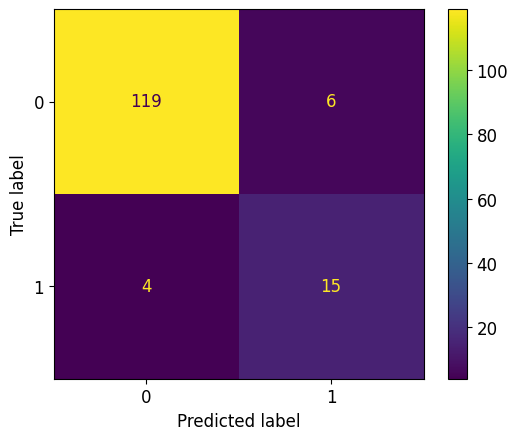

In [90]:
xgb_raw = searcher.best_estimator_
y_pred = xgb_raw.predict(X_test)
cm_t = confusion_matrix(y_test, y_pred, labels=svc_MM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=svc_MM.classes_)
disp.plot()

In [91]:
accuracy_raw= accuracy_score(y_test, y_pred)
f1_raw= f1_score(y_test, y_pred)
print(f'F1 = {f1_raw}, accuracy = {accuracy_raw}')

F1 = 0.7500000000000001, accuracy = 0.9305555555555556


In [92]:
acc_dict2= {
  'accuracy' : [accuracy_xgb_ZS, accuracy_raw] ,
  'Model' : ['xgb_ZS', 'xgb_raw' ]
}
acc_df2 = pd.DataFrame(acc_dict2)
print(acc_df2)

   accuracy    Model
0  0.951389   xgb_ZS
1  0.930556  xgb_raw


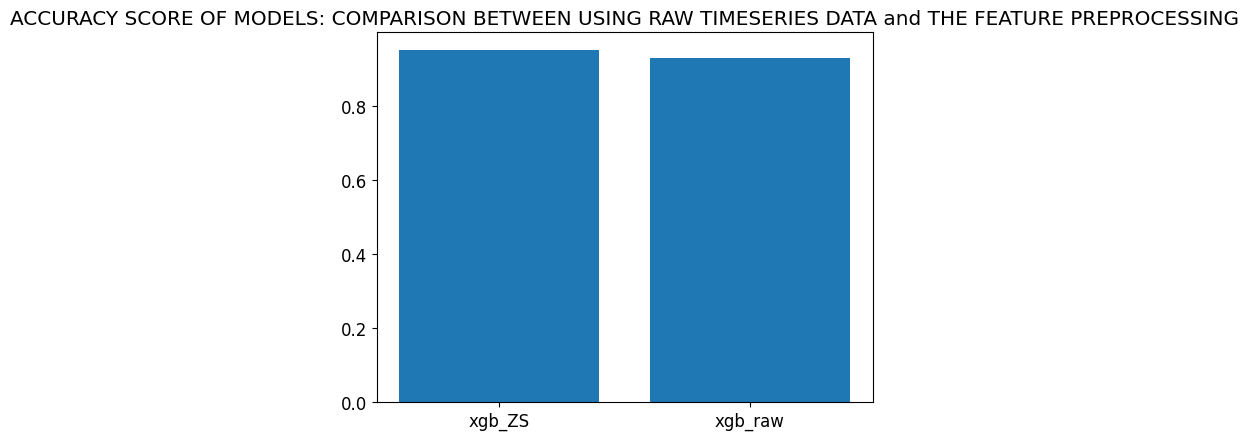

In [93]:
plt.bar(acc_df2['Model'],acc_df2['accuracy'])
plt.title('ACCURACY SCORE OF MODELS: COMPARISON BETWEEN USING RAW TIMESERIES DATA and THE FEATURE PREPROCESSING')
plt.show()

In [94]:
f1_dict2= {
  'accuracy' : [f1_xgb_ZS, f1_raw] ,
  'Model' : ['xgb_ZS', 'xgb_raw' ]
}
f1_df2 = pd.DataFrame(f1_dict2)
print(f1_df2)

   accuracy    Model
0  0.810811   xgb_ZS
1  0.750000  xgb_raw


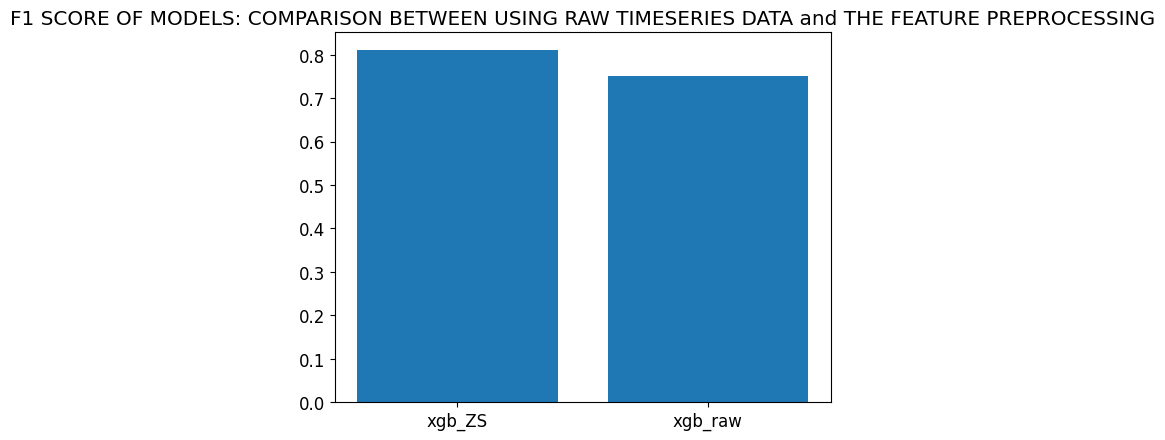

In [95]:
plt.bar(f1_df2['Model'],f1_df2['accuracy'])
plt.title('F1 SCORE OF MODELS: COMPARISON BETWEEN USING RAW TIMESERIES DATA and THE FEATURE PREPROCESSING')
plt.show()